# Project Stage IV (Basic Machine Learning)

### Utilize Linear and Non-Linear (polynomial with degree n) regression models to compare trends for a single state (each member should choose different state) and its counties (top 5 with highest number of cases). Start your data from 2020.06.01 (Monday) to 2021.01.03 (Sunday).

#### X-Axis - number of days, Y-Axis number of new cases and deaths. Calcluate error using RMSE.(10 points)
#### Identify which counties are most at risk. Model for top 5 counties with cases within a state and describe their trends. (10 points)


In [1]:
# Importing required packages
import pandas as pd
import numpy as np
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import make_pipeline
from scipy.stats import pearsonr
import statsmodels.api as sm
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.regression.rolling import RollingOLS
from statsmodels.tools.tools import add_constant
import scipy.stats as st

#### Intially creating and transforming the entire supercovid19 data to perform the required tasks on North Carolina states covid data. Only the data starting from 2020-06-01 to 2021-01-03 is considered.

In [2]:
# Merging the cases, deaths and population covid files to generate supercovid dataset
df_cases=pd.read_csv("../../Data Science/Consumed Datasets/Stage 1/covid_confirmed_usafacts.csv")
df_deaths=pd.read_csv("../../Data Science/Consumed Datasets/Stage 1/covid_deaths_usafacts.csv")
df_population=pd.read_csv("../../Data Science/Consumed Datasets/Stage 1/covid_county_population_usafacts.csv")
Merge_df = pd.merge(df_cases,df_deaths,on=('countyFIPS','County Name','State','StateFIPS'),how='outer')
df_population=df_population.drop(['County Name','State'],axis=1)
df_supercovid19=pd.merge(Merge_df,df_population, on=('countyFIPS'))
df_supercovid19

,countyFIPS,County Name,State,StateFIPS,2020-01-22_x,2020-01-23_x,2020-01-24_x,2020-01-25_x,2020-01-26_x,2020-01-27_x,...,2023-07-15_y,2023-07-16_y,2023-07-17_y,2023-07-18_y,2023-07-19_y,2023-07-20_y,2023-07-21_y,2023-07-22_y,2023-07-23_y,population
0,0,Statewide Unallocated,AL,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,Statewide Unallocated,AL,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,Statewide Unallocated,AL,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,Statewide Unallocated,AL,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,Statewide Unallocated,AL,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5738,56037,Sweetwater County,WY,56,0,0,0,0,0,0,...,142,142,142,142,142,142,142,142,142,42343
5739,56039,Teton County,WY,56,0,0,0,0,0,0,...,16,16,16,16,16,16,16,16,16,23464
5740,56041,Uinta County,WY,56,0,0,0,0,0,0,...,43,43,43,43,43,43,43,43,43,20226
5741,56043,Washakie County,WY,56,0,0,0,0,0,0,...,51,51,51,51,51,51,51,51,51,7805


In [3]:
# Transforming the data model (date columns to rows)
cases_data = df_supercovid19.melt(id_vars=['countyFIPS', 'County Name', 'State', 'StateFIPS', 'population'],
                                       var_name='Date', value_vars=[col for col in df_supercovid19.columns if col.endswith('_x')],
                                       value_name='Cases')

deaths_data = df_supercovid19.melt(id_vars=['countyFIPS', 'County Name', 'State', 'StateFIPS', 'population'],
                                        var_name='Date', value_vars=[col for col in df_supercovid19.columns if col.endswith('_y')],
                                        value_name='Deaths')
print(cases_data)
print(deaths_data)

         countyFIPS            County Name State  StateFIPS  population  \
0                 0  Statewide Unallocated    AL          1           0   
1                 0  Statewide Unallocated    AL          1           0   
2                 0  Statewide Unallocated    AL          1           0   
3                 0  Statewide Unallocated    AL          1           0   
4                 0  Statewide Unallocated    AL          1           0   
...             ...                    ...   ...        ...         ...   
7264890       56037     Sweetwater County     WY         56       42343   
7264891       56039          Teton County     WY         56       23464   
7264892       56041          Uinta County     WY         56       20226   
7264893       56043       Washakie County     WY         56        7805   
7264894       56045         Weston County     WY         56        6927   

                 Date  Cases  
0        2020-01-22_x      0  
1        2020-01-22_x      0  
2     

In [4]:
# Removing the _x and _y suffixes from the Date column in cases_data and deaths_data
cases_data['Date'] = cases_data['Date'].str.replace('_x', '')
deaths_data['Date'] = deaths_data['Date'].str.replace('_y', '')

In [5]:
cases_data

,countyFIPS,County Name,State,StateFIPS,population,Date,Cases
0,0,Statewide Unallocated,AL,1,0,2020-01-22,0
1,0,Statewide Unallocated,AL,1,0,2020-01-22,0
2,0,Statewide Unallocated,AL,1,0,2020-01-22,0
3,0,Statewide Unallocated,AL,1,0,2020-01-22,0
4,0,Statewide Unallocated,AL,1,0,2020-01-22,0
...,...,...,...,...,...,...,...
7264890,56037,Sweetwater County,WY,56,42343,2023-07-23,12645
7264891,56039,Teton County,WY,56,23464,2023-07-23,12206
7264892,56041,Uinta County,WY,56,20226,2023-07-23,6468
7264893,56043,Washakie County,WY,56,7805,2023-07-23,2640


In [6]:
deaths_data

,countyFIPS,County Name,State,StateFIPS,population,Date,Deaths
0,0,Statewide Unallocated,AL,1,0,2020-01-22,0
1,0,Statewide Unallocated,AL,1,0,2020-01-22,0
2,0,Statewide Unallocated,AL,1,0,2020-01-22,0
3,0,Statewide Unallocated,AL,1,0,2020-01-22,0
4,0,Statewide Unallocated,AL,1,0,2020-01-22,0
...,...,...,...,...,...,...,...
7264890,56037,Sweetwater County,WY,56,42343,2023-07-23,142
7264891,56039,Teton County,WY,56,23464,2023-07-23,16
7264892,56041,Uinta County,WY,56,20226,2023-07-23,43
7264893,56043,Washakie County,WY,56,7805,2023-07-23,51


In [7]:
# Defining the date range 
start_date = '2020-06-01'
end_date = '2021-01-03'

# Converting the 'Date' column to datetime format
cases_data['Date'] = pd.to_datetime(cases_data['Date'], format='%Y-%m-%d')
deaths_data['Date'] = pd.to_datetime(deaths_data['Date'], format='%Y-%m-%d')

# Filtering the data for the specified date range
cases_data = cases_data[(cases_data['Date'] >= start_date) & (cases_data['Date'] <= end_date)]
deaths_data = deaths_data[(deaths_data['Date'] >= start_date) & (deaths_data['Date'] <= end_date)]


In [8]:
cases_data

,countyFIPS,County Name,State,StateFIPS,population,Date,Cases
752333,0,Statewide Unallocated,AL,1,0,2020-06-01,0
752334,0,Statewide Unallocated,AL,1,0,2020-06-01,0
752335,0,Statewide Unallocated,AL,1,0,2020-06-01,0
752336,0,Statewide Unallocated,AL,1,0,2020-06-01,0
752337,0,Statewide Unallocated,AL,1,0,2020-06-01,0
...,...,...,...,...,...,...,...
1998559,56037,Sweetwater County,WY,56,42343,2021-01-03,3020
1998560,56039,Teton County,WY,56,23464,2021-01-03,2159
1998561,56041,Uinta County,WY,56,20226,2021-01-03,1570
1998562,56043,Washakie County,WY,56,7805,2021-01-03,783


In [9]:
deaths_data

,countyFIPS,County Name,State,StateFIPS,population,Date,Deaths
752333,0,Statewide Unallocated,AL,1,0,2020-06-01,0
752334,0,Statewide Unallocated,AL,1,0,2020-06-01,0
752335,0,Statewide Unallocated,AL,1,0,2020-06-01,0
752336,0,Statewide Unallocated,AL,1,0,2020-06-01,0
752337,0,Statewide Unallocated,AL,1,0,2020-06-01,0
...,...,...,...,...,...,...,...
1998559,56037,Sweetwater County,WY,56,42343,2021-01-03,16
1998560,56039,Teton County,WY,56,23464,2021-01-03,4
1998561,56041,Uinta County,WY,56,20226,2021-01-03,7
1998562,56043,Washakie County,WY,56,7805,2021-01-03,19


In [10]:
# Forming a single dataframe by merging cases and deaths dataframes
merged_data = cases_data.merge(deaths_data, on=['countyFIPS', 'County Name', 'State', 'StateFIPS', 'population', 'Date'])
merged_data=merged_data.drop_duplicates()
merged_data

,countyFIPS,County Name,State,StateFIPS,population,Date,Cases,Deaths
0,0,Statewide Unallocated,AL,1,0,2020-06-01,0,0
2601,0,Statewide Unallocated,AK,2,0,2020-06-01,2,0
5202,0,Statewide Unallocated,AZ,4,0,2020-06-01,0,0
7803,0,Statewide Unallocated,AR,5,0,2020-06-01,189,0
10404,0,Statewide Unallocated,CA,6,0,2020-06-01,21,0
...,...,...,...,...,...,...,...,...
29467076,56037,Sweetwater County,WY,56,42343,2021-01-03,3020,16
29467077,56039,Teton County,WY,56,23464,2021-01-03,2159,4
29467078,56041,Uinta County,WY,56,20226,2021-01-03,1570,7
29467079,56043,Washakie County,WY,56,7805,2021-01-03,783,19


In [11]:
# Filtering out the data for North Carolina State
nc_data=merged_data[merged_data['State']=='NC']
nc_data

,countyFIPS,County Name,State,StateFIPS,population,Date,Cases,Deaths
85833,0,Statewide Unallocated,NC,37,0,2020-06-01,1,0
134541,37001,Alamance County,NC,37,169509,2020-06-01,364,20
134542,37003,Alexander County,NC,37,37497,2020-06-01,35,0
134543,37005,Alleghany County,NC,37,11137,2020-06-01,17,0
134544,37007,Anson County,NC,37,24446,2020-06-01,65,1
...,...,...,...,...,...,...,...,...
29465924,37191,Wayne County,NC,37,123131,2021-01-03,7656,150
29465925,37193,Wilkes County,NC,37,68412,2021-01-03,4085,73
29465926,37195,Wilson County,NC,37,81801,2021-01-03,5732,108
29465927,37197,Yadkin County,NC,37,37667,2021-01-03,2516,28


In [12]:
# Sorting the data by County Name and Date
nc_data = nc_data.sort_values(by=['County Name', 'Date'])

# Calculating new cases and new deaths for the entire dataset and adding these two new columns to our nc_data dataframe.
nc_data['New Cases'] = nc_data.groupby('County Name')['Cases'].diff().fillna(0)
nc_data['New Deaths'] = nc_data.groupby('County Name')['Deaths'].diff().fillna(0)
nc_data

,countyFIPS,County Name,State,StateFIPS,population,Date,Cases,Deaths,New Cases,New Deaths
134541,37001,Alamance County,NC,37,169509,2020-06-01,364,20,0.0,0.0
270334,37001,Alamance County,NC,37,169509,2020-06-02,368,20,4.0,0.0
406127,37001,Alamance County,NC,37,169509,2020-06-03,382,20,14.0,0.0
541920,37001,Alamance County,NC,37,169509,2020-06-04,398,20,16.0,0.0
677713,37001,Alamance County,NC,37,169509,2020-06-05,427,20,29.0,0.0
...,...,...,...,...,...,...,...,...,...,...
28922756,37199,Yancey County,NC,37,18069,2020-12-30,1020,6,1.0,1.0
29058549,37199,Yancey County,NC,37,18069,2020-12-31,1031,5,11.0,-1.0
29194342,37199,Yancey County,NC,37,18069,2021-01-01,1031,5,0.0,0.0
29330135,37199,Yancey County,NC,37,18069,2021-01-02,1053,5,22.0,0.0


In [13]:
nc_data.loc[nc_data['New Cases'] < 0, 'New Cases'] = 0
nc_data.loc[nc_data['New Deaths'] < 0, 'New Deaths'] = 0

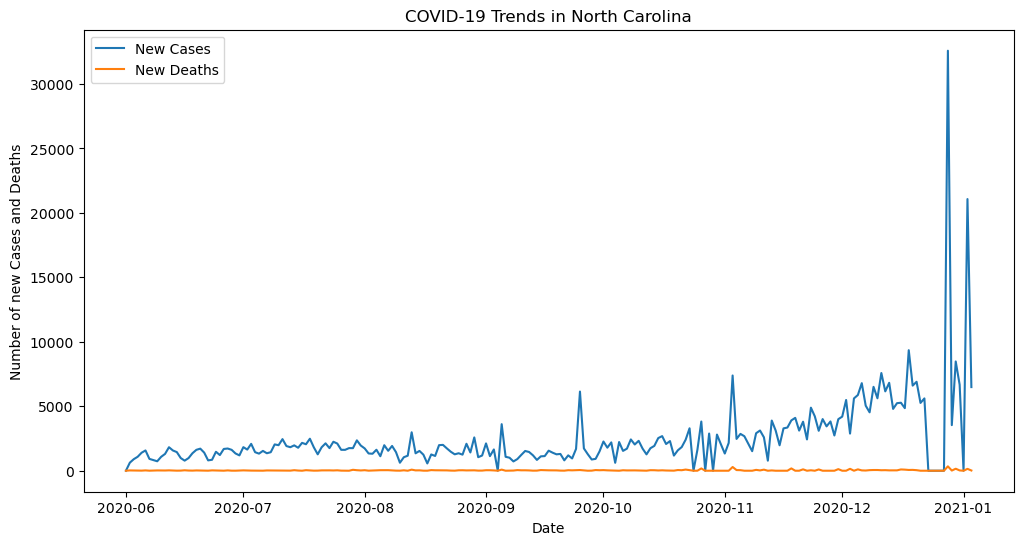

In [14]:
# Creating a new DataFrame for North Carolina's cases and deaths
nc_state_data = nc_data.groupby('Date')[['New Cases', 'New Deaths']].sum().reset_index()

# Plotting the number of new cases and deaths for North Carolina
plt.figure(figsize=(12, 6))
plt.plot(nc_state_data['Date'], nc_state_data['New Cases'], label='New Cases')
plt.plot(nc_state_data['Date'], nc_state_data['New Deaths'], label='New Deaths')
plt.xlabel('Date')
plt.ylabel('Number of new Cases and Deaths')
plt.title('COVID-19 Trends in North Carolina')
plt.legend()
plt.show()


In [15]:
# Calculating the top 5 counties with the highest cases within North Carolina
top_counties = nc_data.groupby('County Name')[['Cases']].max().sort_values(by='Cases', ascending=False).head(5)
top_county_names = top_counties.index.tolist()

# Creating DataFrames for each of the top 5 counties
county_data = {county: nc_data[nc_data['County Name'] == county] for county in top_county_names}
print(top_county_names)
print(county_data)

['Mecklenburg County ', 'Wake County ', 'Guilford County ', 'Forsyth County ', 'Gaston County ']
{'Mecklenburg County ':           countyFIPS          County Name State  StateFIPS  population  \
134600         37119  Mecklenburg County     NC         37     1110356   
270393         37119  Mecklenburg County     NC         37     1110356   
406186         37119  Mecklenburg County     NC         37     1110356   
541979         37119  Mecklenburg County     NC         37     1110356   
677772         37119  Mecklenburg County     NC         37     1110356   
...              ...                  ...   ...        ...         ...   
28922716       37119  Mecklenburg County     NC         37     1110356   
29058509       37119  Mecklenburg County     NC         37     1110356   
29194302       37119  Mecklenburg County     NC         37     1110356   
29330095       37119  Mecklenburg County     NC         37     1110356   
29465888       37119  Mecklenburg County     NC         37     11

['Mecklenburg County ', 'Wake County ', 'Guilford County ', 'Forsyth County ', 'Gaston County '] are five counties at higher risk.

In [16]:
# Defining functions for linear regression, polynomial regression and calculating rsme (root mean square error)
def fit_linear_regression(X, y):
    model = LinearRegression()
    model.fit(X, y)
    return model

def fit_polynomial_regression(X, y, degree):
    poly = PolynomialFeatures(degree=degree)
    X_poly = poly.fit_transform(X)
    model = LinearRegression()
    model.fit(X_poly, y)
    return model

def calculate_rmse(y_true, y_pred):
    return np.sqrt(mean_squared_error(y_true, y_pred))

In [17]:
# Performing regression analysis for North Carolina covid data

# Preparing the data for regression analysis
X_nc = np.arange(len(nc_state_data)).reshape(-1, 1)
y_nc_new_cases = nc_state_data['New Cases']
y_nc_new_deaths = nc_state_data['New Deaths']

RMSE for Linear Regression New Cases, NC: 2637.93
RMSE for Linear Regression New Deaths, NC: 40.22


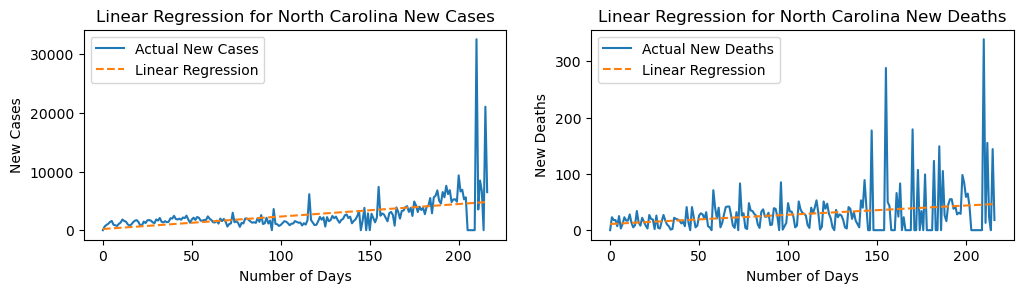

In [18]:
# Fitting linear regression models for the North Carolina data (cases and deaths)
linear_model_new_cases_nc = fit_linear_regression(X_nc, y_nc_new_cases)
linear_model_new_deaths_nc = fit_linear_regression(X_nc, y_nc_new_deaths)

# Predicting with the models
y_pred_linear_new_cases_nc = linear_model_new_cases_nc.predict(X_nc)
y_pred_linear_new_deaths_nc = linear_model_new_deaths_nc.predict(X_nc)

# Calculating RMSE for North Carolina
rmse_linear_new_cases_nc = calculate_rmse(y_nc_new_cases, y_pred_linear_new_cases_nc)
rmse_linear_new_deaths_nc = calculate_rmse(y_nc_new_deaths, y_pred_linear_new_deaths_nc)

# Plotting the results for North Carolina as a whole
plt.figure(figsize=(12, 6))

# Linear Regression Plots
plt.subplot(221)
plt.plot(X_nc, y_nc_new_cases, label='Actual New Cases')
plt.plot(X_nc, y_pred_linear_new_cases_nc, label='Linear Regression', linestyle='--')
plt.xlabel('Number of Days')
plt.ylabel('New Cases')
plt.title('Linear Regression for North Carolina New Cases')
plt.legend()

plt.subplot(222)
plt.plot(X_nc, y_nc_new_deaths, label='Actual New Deaths')
plt.plot(X_nc, y_pred_linear_new_deaths_nc, label='Linear Regression', linestyle='--')
plt.xlabel('Number of Days')
plt.ylabel('New Deaths')
plt.title('Linear Regression for North Carolina New Deaths')
plt.legend()

print(f"RMSE for Linear Regression New Cases, NC: {rmse_linear_new_cases_nc:.2f}")
print(f"RMSE for Linear Regression New Deaths, NC: {rmse_linear_new_deaths_nc:.2f}")

Here, I am choosing a degree 3 in polynomial regression because a higher degreee allows the model to capture more intricate relationships, the reason behind me limiting it to 3 is an excessively higher degree may lead to overfitting. I feel degree 3 may strike a balance by accomodating some curvature without unnecessary complexity. I will be using same degree in later tasks (in further codes as well).

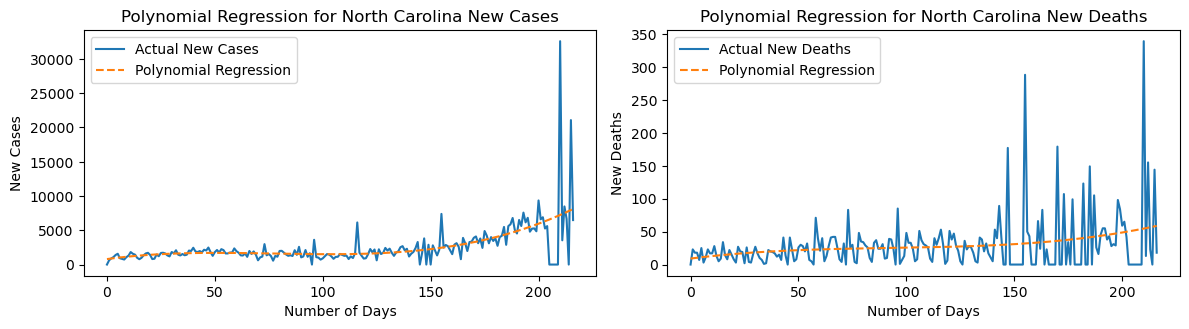

RMSE for Polynomial Regression New Cases, NC: 2429.78
RMSE for Polynomial Regression New Deaths, NC: 40.06


In [19]:
# Fitting polynomial regression models for the North Carolina data (cases and deaths)
degree = 3  # choosing the degree 3 for the polynomial
poly = PolynomialFeatures(degree=degree)  # Defining the poly object
X_poly_nc = poly.fit_transform(X_nc)
poly_model_new_cases_nc = fit_linear_regression(X_poly_nc, y_nc_new_cases)
poly_model_new_deaths_nc = fit_linear_regression(X_poly_nc, y_nc_new_deaths)

# Predicting with the models
y_pred_poly_new_cases_nc = poly_model_new_cases_nc.predict(X_poly_nc)
y_pred_poly_new_deaths_nc = poly_model_new_deaths_nc.predict(X_poly_nc)

# Calculating RMSE for North Carolina
rmse_poly_new_cases_nc = calculate_rmse(y_nc_new_cases, y_pred_poly_new_cases_nc)
rmse_poly_new_deaths_nc = calculate_rmse(y_nc_new_deaths, y_pred_poly_new_deaths_nc)

# Plotting the results for North Carolina as a whole
plt.figure(figsize=(12, 6))

# Polynomial Regression Plots
plt.subplot(223)
plt.plot(X_nc, y_nc_new_cases, label='Actual New Cases')
plt.plot(X_nc, y_pred_poly_new_cases_nc, label='Polynomial Regression', linestyle='--')
plt.xlabel('Number of Days')
plt.ylabel('New Cases')
plt.title('Polynomial Regression for North Carolina New Cases')
plt.legend()

plt.subplot(224)
plt.plot(X_nc, y_nc_new_deaths, label='Actual New Deaths')
plt.plot(X_nc, y_pred_poly_new_deaths_nc, label='Polynomial Regression', linestyle='--')
plt.xlabel('Number of Days')
plt.ylabel('New Deaths')
plt.title('Polynomial Regression for North Carolina New Deaths')
plt.legend()

plt.tight_layout()

plt.show()

print(f"RMSE for Polynomial Regression New Cases, NC: {rmse_poly_new_cases_nc:.2f}")
print(f"RMSE for Polynomial Regression New Deaths, NC: {rmse_poly_new_deaths_nc:.2f}")


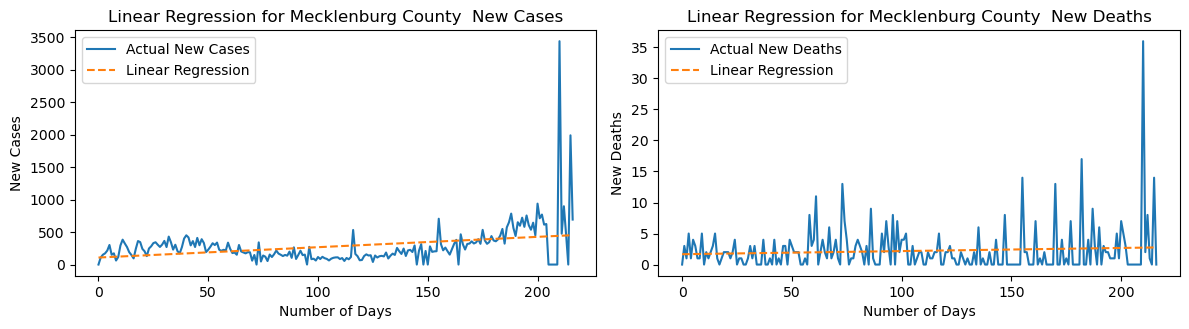

County: Mecklenburg County 
RMSE for Linear Regression New Cases: 287.94
RMSE for Linear Regression New Deaths: 3.68


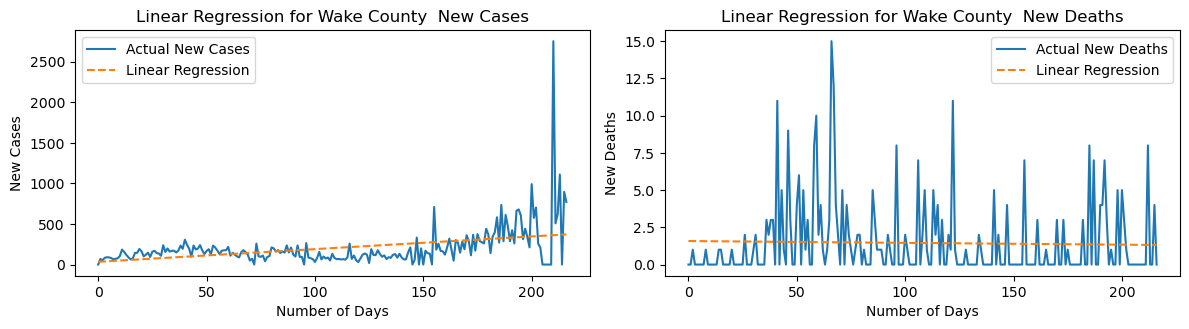

County: Wake County 
RMSE for Linear Regression New Cases: 226.28
RMSE for Linear Regression New Deaths: 2.55


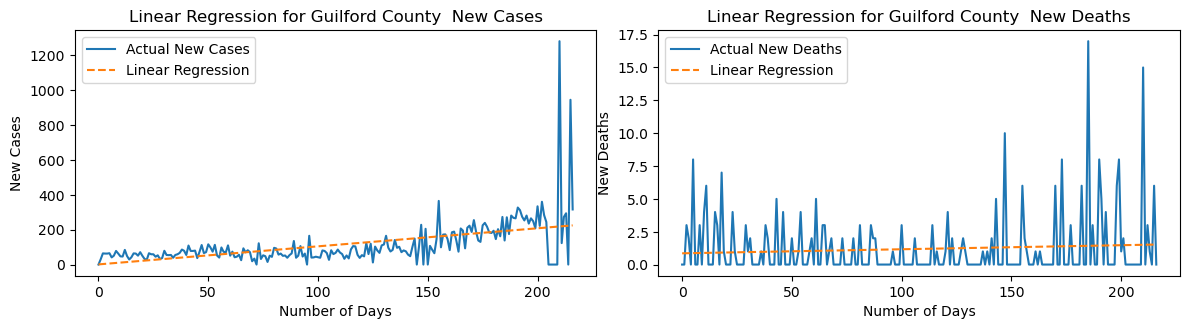

County: Guilford County 
RMSE for Linear Regression New Cases: 109.07
RMSE for Linear Regression New Deaths: 2.39


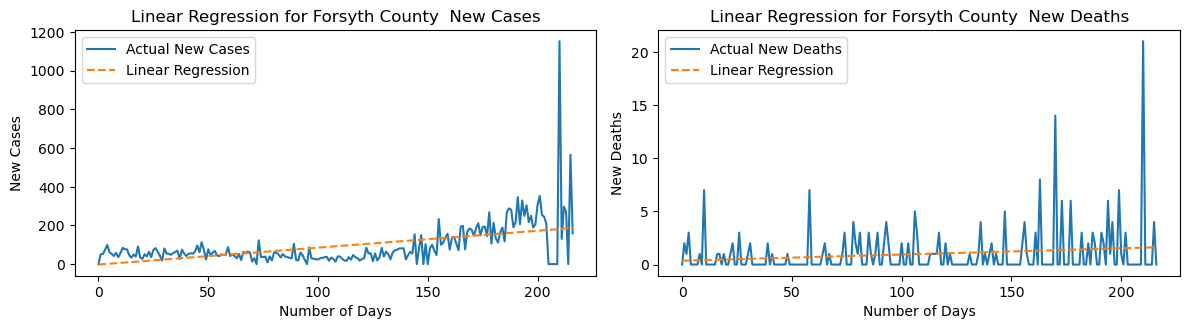

County: Forsyth County 
RMSE for Linear Regression New Cases: 95.55
RMSE for Linear Regression New Deaths: 2.22


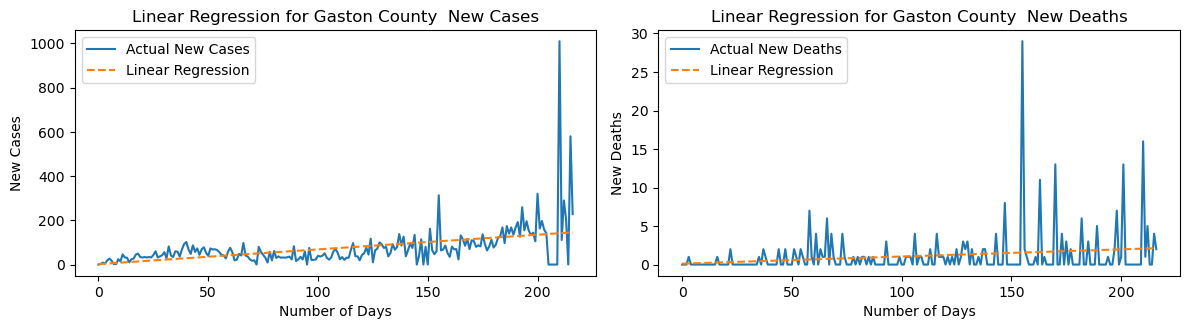

County: Gaston County 
RMSE for Linear Regression New Cases: 81.33
RMSE for Linear Regression New Deaths: 2.86


In [20]:
# Performing linear regression analysis for the top 5 counties of NC state
for county_name in top_county_names:
    county_data_df = county_data[county_name]

    X_county = np.arange(len(county_data_df)).reshape(-1, 1)
    y_county_new_cases = county_data_df['New Cases']
    y_county_new_deaths = county_data_df['New Deaths']

    # Fitting linear regression models
    linear_model_new_cases_county = fit_linear_regression(X_county, y_county_new_cases)
    linear_model_new_deaths_county = fit_linear_regression(X_county, y_county_new_deaths)

    # Predicting with the models
    y_pred_linear_new_cases_county = linear_model_new_cases_county.predict(X_county)
    y_pred_linear_new_deaths_county = linear_model_new_deaths_county.predict(X_county)
    
    # Calculating RMSE for the county
    rmse_linear_new_cases_county = calculate_rmse(y_county_new_cases, y_pred_linear_new_cases_county)
    rmse_linear_new_deaths_county = calculate_rmse(y_county_new_deaths, y_pred_linear_new_deaths_county)
   
    # Plotting the results for the county
    plt.figure(figsize=(12, 6))

    # Linear Regression Plots
    plt.subplot(221)
    plt.plot(X_county, y_county_new_cases, label='Actual New Cases')
    plt.plot(X_county, y_pred_linear_new_cases_county, label='Linear Regression', linestyle='--')
    plt.xlabel('Number of Days')
    plt.ylabel('New Cases')
    plt.title(f'Linear Regression for {county_name} New Cases')
    plt.legend()

    plt.subplot(222)
    plt.plot(X_county, y_county_new_deaths, label='Actual New Deaths')
    plt.plot(X_county, y_pred_linear_new_deaths_county, label='Linear Regression', linestyle='--')
    plt.xlabel('Number of Days')
    plt.ylabel('New Deaths')
    plt.title(f'Linear Regression for {county_name} New Deaths')
    plt.legend()

   
    plt.tight_layout()

    plt.show()
    
    print(f"County: {county_name}")
    print(f"RMSE for Linear Regression New Cases: {rmse_linear_new_cases_county:.2f}")
    print(f"RMSE for Linear Regression New Deaths: {rmse_linear_new_deaths_county:.2f}")

The RSME value indicates the level of accuracy of the linear regression model for predicting the new cases and new deaths in the top 5 counties of North Carolina. Lower RSME value suggests better model performance.

My interpretation on above results:
Gaston county has lowest RSME for both new cases and new deaths, which indicates most accurate predictions among all other counties.
Forstyn and Guilford show moderate RSME values, suggesting reasonably accurate predictions.
Wake and Mecklenburg counties have higher RSME values, indicating challenges in accurately predicting new cases and new deaths.

This implies, Gaston county's linear regression model performs relatively well, when compared with other counties.

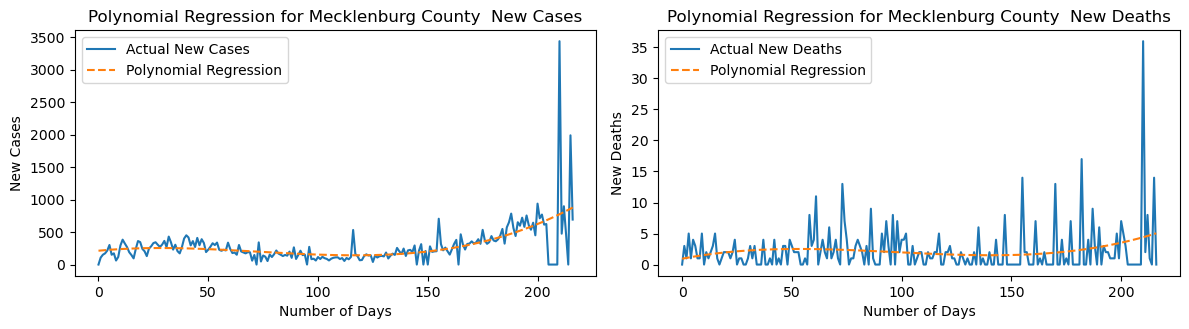

County: Mecklenburg County 
RMSE for Polynomial Regression New Cases: 254.18
RMSE for Polynomial Regression New Deaths: 3.61


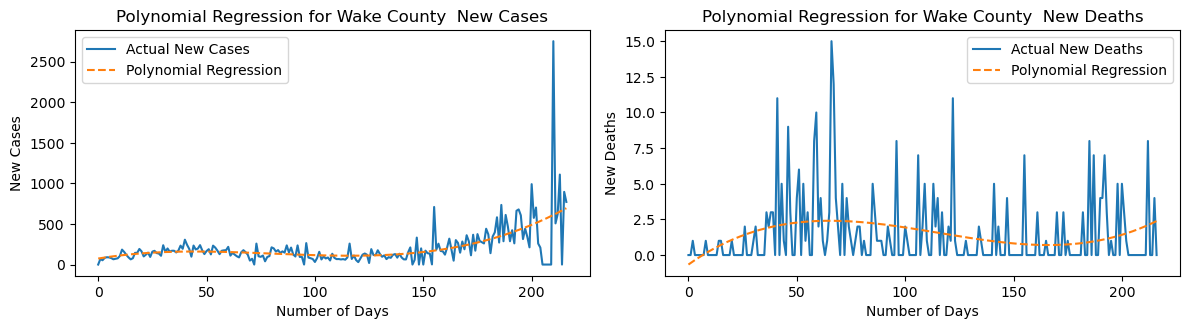

County: Wake County 
RMSE for Polynomial Regression New Cases: 203.58
RMSE for Polynomial Regression New Deaths: 2.45


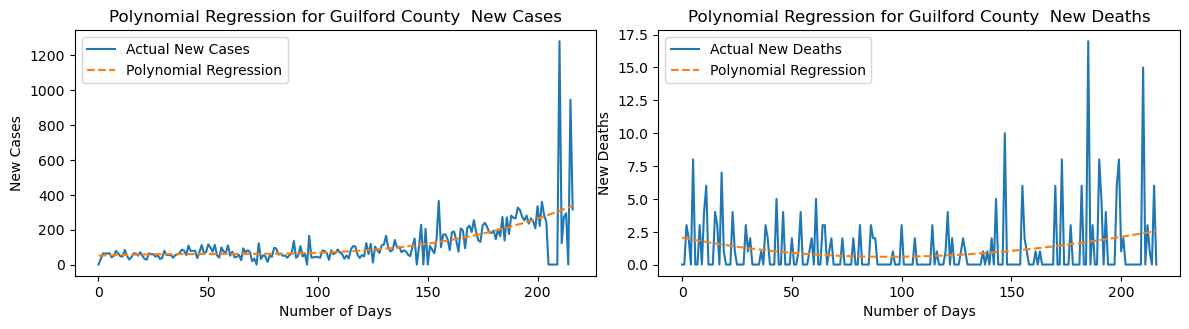

County: Guilford County 
RMSE for Polynomial Regression New Cases: 101.96
RMSE for Polynomial Regression New Deaths: 2.34


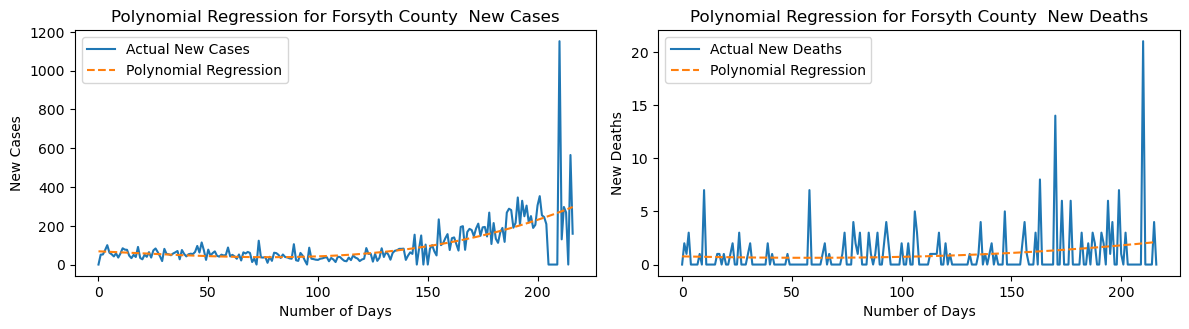

County: Forsyth County 
RMSE for Polynomial Regression New Cases: 85.97
RMSE for Polynomial Regression New Deaths: 2.21


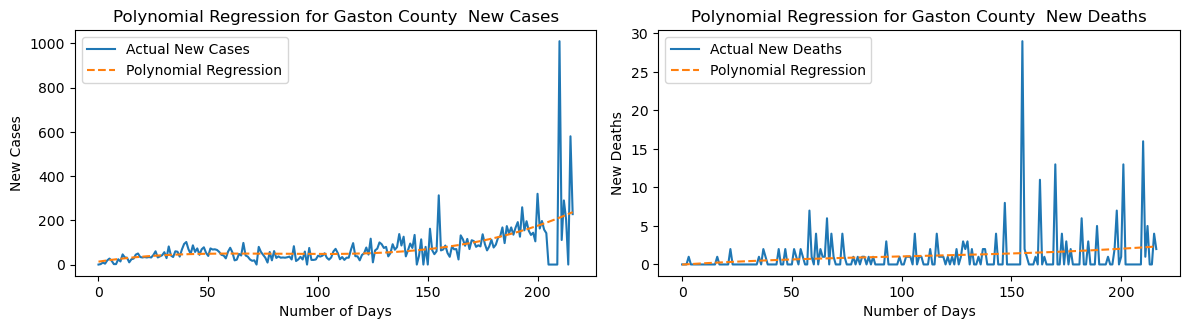

County: Gaston County 
RMSE for Polynomial Regression New Cases: 76.37
RMSE for Polynomial Regression New Deaths: 2.86


In [21]:
# Performing polynomial regression analysis for the top 5 counties of the NC state 
for county_name in top_county_names:
    county_data_df = county_data[county_name]

    X_county = np.arange(len(county_data_df)).reshape(-1, 1)
    y_county_new_cases = county_data_df['New Cases']
    y_county_new_deaths = county_data_df['New Deaths']

    # Fitting polynomial regression models
    poly = PolynomialFeatures(degree=degree)  # Define the poly object for each county
    X_poly_county = poly.fit_transform(X_county)
    poly_model_new_cases_county = fit_linear_regression(X_poly_county, y_county_new_cases)
    poly_model_new_deaths_county = fit_linear_regression(X_poly_county, y_county_new_deaths)

    # Predicting with the models
    y_pred_poly_new_cases_county = poly_model_new_cases_county.predict(X_poly_county)
    y_pred_poly_new_deaths_county = poly_model_new_deaths_county.predict(X_poly_county)

    # Calculating RMSE for the county
    rmse_poly_new_cases_county = calculate_rmse(y_county_new_cases, y_pred_poly_new_cases_county)
    rmse_poly_new_deaths_county = calculate_rmse(y_county_new_deaths, y_pred_poly_new_deaths_county)
    
    # Plotting the results for the county
    plt.figure(figsize=(12, 6))

    # Polynomial Regression Plots
    plt.subplot(223)
    plt.plot(X_county, y_county_new_cases, label='Actual New Cases')
    plt.plot(X_county, y_pred_poly_new_cases_county, label='Polynomial Regression', linestyle='--')
    plt.xlabel('Number of Days')
    plt.ylabel('New Cases')
    plt.title(f'Polynomial Regression for {county_name} New Cases')
    plt.legend()

    plt.subplot(224)
    plt.plot(X_county, y_county_new_deaths, label='Actual New Deaths')
    plt.plot(X_county, y_pred_poly_new_deaths_county, label='Polynomial Regression', linestyle='--')
    plt.xlabel('Number of Days')
    plt.ylabel('New Deaths')
    plt.title(f'Polynomial Regression for {county_name} New Deaths')
    plt.legend()

    plt.tight_layout()

    plt.show()
    
    print(f"County: {county_name}")
    print(f"RMSE for Polynomial Regression New Cases: {rmse_poly_new_cases_county:.2f}")
    print(f"RMSE for Polynomial Regression New Deaths: {rmse_poly_new_deaths_county:.2f}")

Same as above, the RSME value for polynomial regression model with degree 3 indicates the level of accuracy of the model for predicting the new cases and new deaths in the top 5 counties of North Carolina. Lower RSME value suggests better model performance.

My interpretation on above results:
Gaston county has lowest RSME for both new cases and new deaths, which indicates most accurate predictions among all other counties. Here the results suggests improved prediction accuracy compared to linear regression.
Forstyn and Guilford show moderate RSME values, indicates slight improved performance compared to linear regression.
Wake and Mecklenburg counties to have higher RSME values, indicating challenges in accurately predicting new cases and new deaths even with new model.

The polynomial regression in total generally improves accuracy, but chaallenges in prediction persist for wake and mecklenburg counties.

#### Perform hypothesis tests on questions identified in Stage III. (20 points

#### Initially transforming enrichment data to perform the hypothesis testing

In [22]:
# Reading enrichment data into a dataframe and displaying the data.
df_enrichment=pd.read_csv("../Consumed Datasets/Stage 1/Enrichment Datasets/Presidential Elections/president_county_candidate.csv")
df_enrichment

,state,county,candidate,party,total_votes,won
0,Delaware,Kent County,Joe Biden,DEM,44552,True
1,Delaware,Kent County,Donald Trump,REP,41009,False
2,Delaware,Kent County,Jo Jorgensen,LIB,1044,False
3,Delaware,Kent County,Howie Hawkins,GRN,420,False
4,Delaware,New Castle County,Joe Biden,DEM,195034,True
...,...,...,...,...,...,...
32172,Arizona,Maricopa County,Write-ins,WRI,1331,False
32173,Arizona,Mohave County,Donald Trump,REP,78535,True
32174,Arizona,Mohave County,Joe Biden,DEM,24831,False
32175,Arizona,Mohave County,Jo Jorgensen,LIB,1302,False


In [23]:
# Reading the additional source for state notations
df_notations=pd.read_csv("../Consumed Datasets/Stage 1/Enrichment Datasets/Presidential Elections/State notations.csv")
df_notations

,state,State
0,Alabama,AL
1,Alaska,AK
2,Arizona,AZ
3,Arkansas,AR
4,California,CA
5,Colorado,CO
6,Connecticut,CT
7,Delaware,DE
8,District of Columbia,DC
9,Florida,FL


In [24]:
# Adding the state short hand notation column to the enrichment dataset
df_enrichmentdataset = df_enrichment.merge(df_notations, on='state', how='left')
# Renaming county column to 'County Name' 
df_enrichmentdataset = df_enrichmentdataset.rename(columns={'county': 'County Name'})
df_enrichmentdataset

,state,County Name,candidate,party,total_votes,won,State
0,Delaware,Kent County,Joe Biden,DEM,44552,True,DE
1,Delaware,Kent County,Donald Trump,REP,41009,False,DE
2,Delaware,Kent County,Jo Jorgensen,LIB,1044,False,DE
3,Delaware,Kent County,Howie Hawkins,GRN,420,False,DE
4,Delaware,New Castle County,Joe Biden,DEM,195034,True,DE
...,...,...,...,...,...,...,...
32172,Arizona,Maricopa County,Write-ins,WRI,1331,False,AZ
32173,Arizona,Mohave County,Donald Trump,REP,78535,True,AZ
32174,Arizona,Mohave County,Joe Biden,DEM,24831,False,AZ
32175,Arizona,Mohave County,Jo Jorgensen,LIB,1302,False,AZ


In [25]:
# Filtering 'NC' enrichment data
nc_enrichment_data=df_enrichmentdataset[df_enrichmentdataset['State']=='NC']

In [26]:
nc_enrichmentdata=nc_enrichment_data.copy()
# Filtering for the democratic, Republican and Libertarian parties
filtered_data = nc_enrichmentdata[(nc_enrichmentdata['party'] == 'DEM') | (nc_enrichmentdata['party'] == 'REP') | (nc_enrichmentdata['party'] == 'LIB')]

# Pivoting the data to create columns for each party's votes
pivoted_data = filtered_data.pivot_table(index=['County Name', 'candidate'],
                                         columns='party',
                                         values='total_votes',
                                         aggfunc='sum',
                                         fill_value=0)

# Resetting the index and renaming columns
pivoted_data = pivoted_data.reset_index()
pivoted_data.columns.name = None
pivoted_data = pivoted_data.rename(columns={'DEM': 'dem_votes', 'REP': 'rep_votes', 'LIB': 'lib_votes'})

# Grouping by county and and aggregating data.
grouped_data = pivoted_data.groupby('County Name').agg({'dem_votes': 'sum', 'rep_votes': 'sum', 'lib_votes': 'sum'}).reset_index()

# Calculating the total votes by summing the votes of the three parties choosen.
grouped_data['total_votes'] = grouped_data['dem_votes'] + grouped_data['rep_votes'] + grouped_data['lib_votes']

Enrichment_data = grouped_data.groupby('County Name').agg({'dem_votes': 'sum', 'rep_votes': 'sum', 'lib_votes': 'sum', 'total_votes': 'sum'}).reset_index()
Enrichment_data

,County Name,dem_votes,rep_votes,lib_votes,total_votes
0,Alamance County,38825,46056,686,85567
1,Alexander County,4145,15888,127,20160
2,Alleghany County,1486,4527,35,6048
3,Anson County,5789,5321,41,11151
4,Ashe County,4164,11451,126,15741
...,...,...,...,...,...
95,Wayne County,24215,30709,378,55302
96,Wilkes County,7511,27592,214,35317
97,Wilson County,20754,19581,245,40580
98,Yadkin County,3763,15933,131,19827


In [27]:
# Grouping by 'countyFIPS' and 'County Name' and aggregating 'cases' and 'population'
county_aggregated_df = nc_data.groupby(['countyFIPS', 'County Name']).agg({
    'Cases': 'sum',
    'New Cases': 'sum',
    'population': 'max'  # As population is constant for a county
}).reset_index()

nc_covidcases=county_aggregated_df.copy()

# Renaming the aggregated 'cases' column for clarity 
nc_covidcases = nc_covidcases.rename(columns={'Cases': 'total_cases'})
nc_covidcases = nc_covidcases.rename(columns={'New Cases': 'new_cases'})
nc_covidcases

# Trimming left and right spaces of 'County Name' column values
nc_covidcases['County Name'] = nc_covidcases['County Name'].str.strip()

nc_covidcases

,countyFIPS,County Name,total_cases,new_cases,population
0,0,Statewide Unallocated,27484,3554.0,0
1,37001,Alamance County,896325,10512.0,169509
2,37003,Alexander County,166367,2771.0,37497
3,37005,Alleghany County,50923,659.0,11137
4,37007,Anson County,123392,1417.0,24446
...,...,...,...,...,...
96,37191,Wayne County,791070,6495.0,123131
97,37193,Wilkes County,326951,3585.0,68412
98,37195,Wilson County,511826,5373.0,81801
99,37197,Yadkin County,193420,2339.0,37667


In [28]:
# Merging the DataFrames and filter for North Carolina
NC_enrichment_covid = pd.merge(nc_covidcases, Enrichment_data, on='County Name',how='inner')

# Grouping by data and calculate aggregate values
agg_functions = {
    'total_cases': 'mean',
    'new_cases': 'mean',
    'total_votes': 'max',
    'dem_votes': 'max',
    'rep_votes': 'max',
    'lib_votes': 'max'
}

NC_enrichment_covid = NC_enrichment_covid.groupby(['County Name', 'population']).agg(agg_functions).reset_index()

# Converting 'Cases' to integers
NC_enrichment_covid['total_cases'] = NC_enrichment_covid['total_cases'].astype(int)
NC_enrichment_covid['new_cases'] = NC_enrichment_covid['new_cases'].astype(int)

NC_enrichment_covid

,County Name,population,total_cases,new_cases,total_votes,dem_votes,rep_votes,lib_votes
0,Alamance County,169509,896325,10512,85567,38825,46056,686
1,Alexander County,37497,166367,2771,20160,4145,15888,127
2,Alleghany County,11137,50923,659,6048,1486,4527,35
3,Anson County,24446,123392,1417,11151,5789,5321,41
4,Ashe County,27203,80966,1276,15741,4164,11451,126
...,...,...,...,...,...,...,...,...
95,Wayne County,123131,791070,6495,55302,24215,30709,378
96,Wilkes County,68412,326951,3585,35317,7511,27592,214
97,Wilson County,81801,511826,5373,40580,20754,19581,245
98,Yadkin County,37667,193420,2339,19827,3763,15933,131


In [29]:
# Normalizing the data per 10000 population.
columns_to_normalize = ['total_cases','new_cases' ,'total_votes', 'dem_votes', 'rep_votes', 'lib_votes']

# Looping through the columns and performing normalization
for column in columns_to_normalize:
    NC_enrichment_covid[column] = (NC_enrichment_covid[column] / NC_enrichment_covid['population']) * 10000

# Converting the columns to integers
int_columns = columns_to_normalize 
NC_enrichment_covid[int_columns] = NC_enrichment_covid[int_columns].astype(int)

NC_enrichment_covid

,County Name,population,total_cases,new_cases,total_votes,dem_votes,rep_votes,lib_votes
0,Alamance County,169509,52877,620,5047,2290,2717,40
1,Alexander County,37497,44368,738,5376,1105,4237,33
2,Alleghany County,11137,45724,591,5430,1334,4064,31
3,Anson County,24446,50475,579,4561,2368,2176,16
4,Ashe County,27203,29763,469,5786,1530,4209,46
...,...,...,...,...,...,...,...,...
95,Wayne County,123131,64246,527,4491,1966,2494,30
96,Wilkes County,68412,47791,524,5162,1097,4033,31
97,Wilson County,81801,62569,656,4960,2537,2393,29
98,Yadkin County,37667,51349,620,5263,999,4229,34


The hypothesis formulated in Stage III are:

Hypothesis 1: (total_cases vs DEM_votes)

Null Hypothesis (H0): There is no significant correlation between the total number of Democratic (dem_votes) votes and the total number of COVID-19 cases.
Alternative Hypothesis (H1): There is a significant correlation between the total number of Democratic votes and the total number of COVID-19 cases.

Hypothesis 2: (total_cases vs REP_votes)

Null Hypothesis (H0): There is no significant correlation between the total number of Republican (rep_votes) votes and the total number of COVID-19 cases.
Alternative Hypothesis (H1): There is a significant correlation between the total number of Republican votes and the total number of COVID-19 cases.

Hypothesis 3: (total_cases vs LIB_votes)

Null Hypothesis (H0): There is no significant correlation between the total number of Libertarian (lib_votes) votes and the total number of COVID-19 cases.
Alternative Hypothesis (H1): There is a significant correlation between the total number of Libertarian votes and the total number of COVID-19 cases.

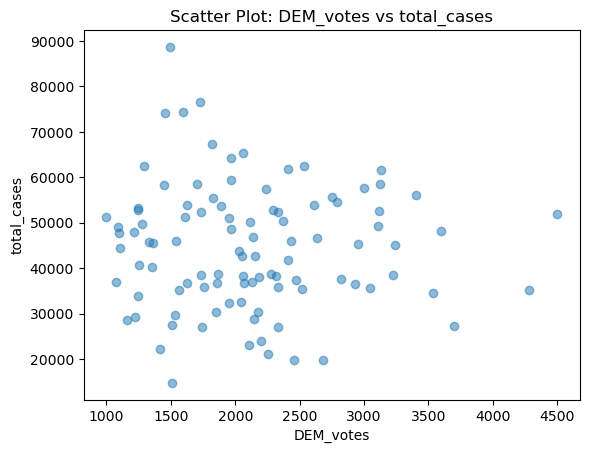

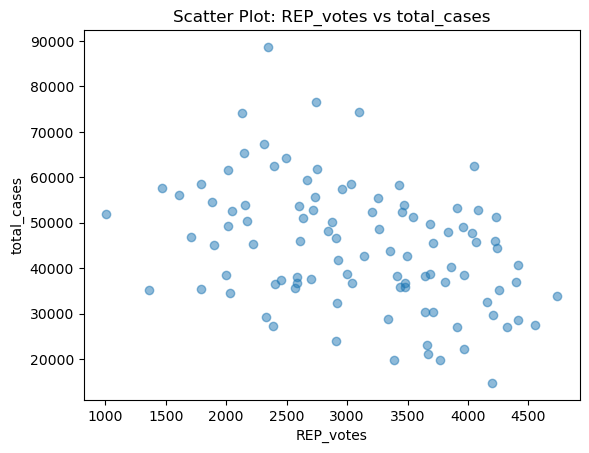

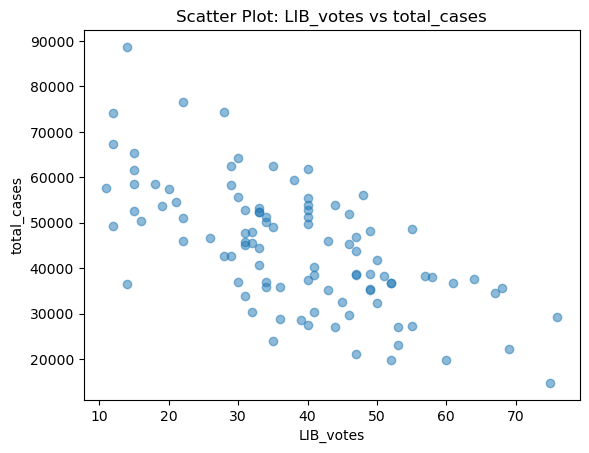

In [30]:
# Function to create scatter plot
def create_scatter_plot(x, y, x_label, y_label, title):
    plt.scatter(x, y, alpha=0.5)
    plt.title(title)
    plt.xlabel(x_label)
    plt.ylabel(y_label)
    plt.show()

# Scatter plot for Hypothesis 1: (total_cases vs DEM_votes)
create_scatter_plot(NC_enrichment_covid['dem_votes'], NC_enrichment_covid['total_cases'],
                    'DEM_votes', 'total_cases', 'Scatter Plot: DEM_votes vs total_cases')

# Scatter plot for Hypothesis 2: (total_cases vs REP_votes)
create_scatter_plot(NC_enrichment_covid['rep_votes'], NC_enrichment_covid['total_cases'],
                    'REP_votes', 'total_cases', 'Scatter Plot: REP_votes vs total_cases')

# Scatter plot for Hypothesis 3: (total_cases vs LIB_votes)
create_scatter_plot(NC_enrichment_covid['lib_votes'], NC_enrichment_covid['total_cases'],
                    'LIB_votes', 'total_cases', 'Scatter Plot: LIB_votes vs total_cases')

On interpretting the scatter plots, i observe that the plots clearly indicates a negative relationship (as one variable increases the other decreases) and the patterns are not so clear (there is no strict trend followed) and the outliers present are very less.

Using the Pearson correlation coefficient to perform the hypothesis testing.

In [31]:
# Hypothesis 1: (total_cases vs DEM_votes)
total_cases_dem, dem_votes = NC_enrichment_covid['total_cases'], NC_enrichment_covid['dem_votes']
corr_coeff_dem, p_value_dem = pearsonr(total_cases_dem, dem_votes)

alpha = 0.05

if p_value_dem < alpha:
    print(f'Hypothesis 1: Reject the null hypothesis. There is a significant negative correlation between Democratic votes and total covid-19 cases.')
else:
    print(f'Hypothesis 1: Accept the null hypothesis. There is no significant correlation between Democratic votes and total covid-19 cases.')

# Hypothesis 2: (total_cases vs REP_votes)
total_cases_rep, rep_votes = NC_enrichment_covid['total_cases'], NC_enrichment_covid['rep_votes']
corr_coeff_rep, p_value_rep = pearsonr(total_cases_rep, rep_votes)

if p_value_rep < alpha:
    print(f'Hypothesis 2: Reject the null hypothesis. There is a significant negative correlation between Republican votes and total covid-19 cases.')
else:
    print(f'Hypothesis 2: Accept the null hypothesis. There is no significant correlation between Republican votes and total covid-19 cases.')

# Hypothesis 3: (total_cases vs LIB_votes)
total_cases_lib, lib_votes = NC_enrichment_covid['total_cases'], NC_enrichment_covid['lib_votes']
corr_coeff_lib, p_value_lib = pearsonr(total_cases_lib, lib_votes)

if p_value_lib < alpha:
    print(f'Hypothesis 3: Reject the null hypothesis. There is a significant negative correlation between Libertarian votes and total covid-19 cases.')
else:
    print(f'Hypothesis 3: Accept the null hypothesis. There is no significant correlation between Libertarian votes and total covid-19 cases.')

Hypothesis 1: Accept the null hypothesis. There is no significant correlation between Democratic votes and total covid-19 cases.
Hypothesis 2: Reject the null hypothesis. There is a significant negative correlation between Republican votes and total covid-19 cases.
Hypothesis 3: Reject the null hypothesis. There is a significant negative correlation between Libertarian votes and total covid-19 cases.


An additional testing approach, Using linear regression for hypothesis testing 

In [32]:
# Hypothesis 1
total_cases_dem, dem_votes = NC_enrichment_covid['total_cases'], NC_enrichment_covid['dem_votes']
X_dem = sm.add_constant(dem_votes)

model_dem = sm.OLS(total_cases_dem, X_dem).fit()
p_value_dem_regression = model_dem.pvalues[1]

alpha = 0.05

if p_value_dem_regression < alpha:
    print(f'Hypothesis 1: Reject the null hypothesis. There is a significant impact of Democratic votes on total COVID-19 cases.')
else:
    print(f'Hypothesis 1: Accept the null hypothesis. There is no significant impact of Democratic votes on total COVID-19 cases.')


Hypothesis 1: Accept the null hypothesis. There is no significant impact of Democratic votes on total COVID-19 cases.


In [33]:
# Hypothesis 2
total_cases_rep, rep_votes = NC_enrichment_covid['total_cases'], NC_enrichment_covid['rep_votes']
X_rep = sm.add_constant(rep_votes)

model_rep = sm.OLS(total_cases_rep, X_rep).fit()
p_value_rep_regression = model_rep.pvalues[1]

alpha = 0.05

if p_value_rep_regression < alpha:
    print(f'Hypothesis 2: Reject the null hypothesis. There is a significant impact of Republican votes on total COVID-19 cases.')
else:
    print(f'Hypothesis 2: Accept the null hypothesis. There is no significant impact of Republican votes on total COVID-19 cases.')


Hypothesis 2: Reject the null hypothesis. There is a significant impact of Republican votes on total COVID-19 cases.


In [34]:
# Hypothesis 3
total_cases_lib, lib_votes = NC_enrichment_covid['total_cases'], NC_enrichment_covid['lib_votes']
X_lib = sm.add_constant(lib_votes)

model_lib = sm.OLS(total_cases_lib, X_lib).fit()
p_value_lib_regression = model_lib.pvalues[1]

alpha = 0.05

if p_value_lib_regression < alpha:
    print(f'Hypothesis 3: Reject the null hypothesis. There is a significant impact of Libertarian votes on total COVID-19 cases.')
else:
    print(f'Hypothesis 3: Accept the null hypothesis. There is no significant impact of Libertarian votes on total COVID-19 cases.')


Hypothesis 3: Reject the null hypothesis. There is a significant impact of Libertarian votes on total COVID-19 cases.


In Stage III i have formulated the hypothesis and computed the correlation on total cases versus three different presidential political party's. And in the above cells i have performed the hypothesis testing on the same (the hypothesis formulated in Stage III). In the below cells i am performing hypothesis tetsing on the new cases instead of tatl cases with the three different parties.

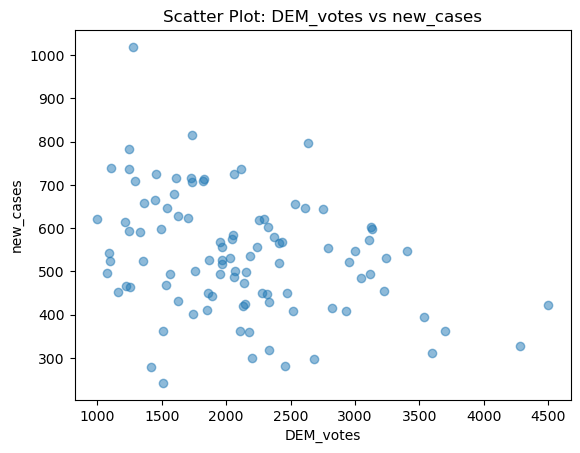

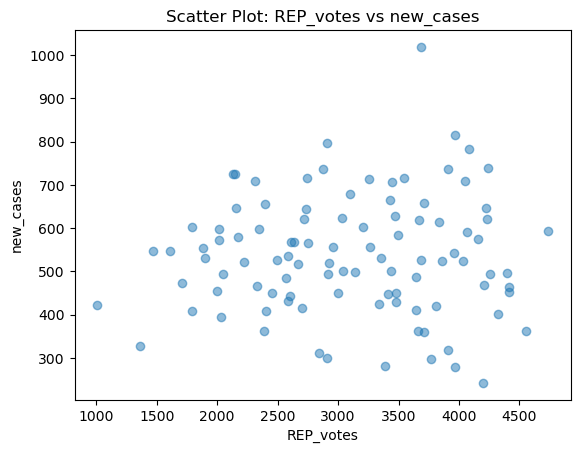

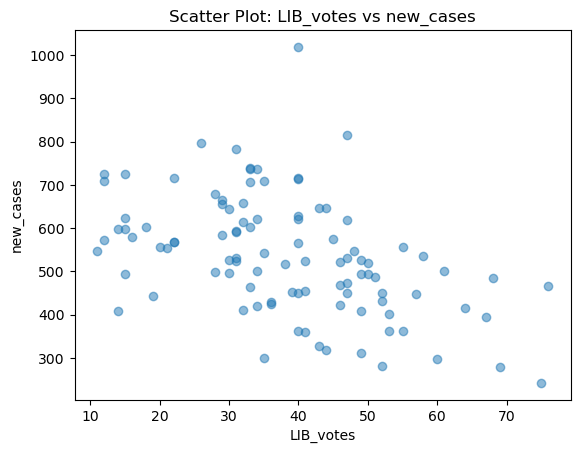

In [35]:
# Function to create scatter plot
def create_scatter_plot(x, y, x_label, y_label, title):
    plt.scatter(x, y, alpha=0.5)
    plt.title(title)
    plt.xlabel(x_label)
    plt.ylabel(y_label)
    plt.show()

# Scatter plot for Hypothesis 1: (new_cases vs DEM_votes)
create_scatter_plot(NC_enrichment_covid['dem_votes'], NC_enrichment_covid['new_cases'],
                    'DEM_votes', 'new_cases', 'Scatter Plot: DEM_votes vs new_cases')

# Scatter plot for Hypothesis 2: (new_cases vs REP_votes)
create_scatter_plot(NC_enrichment_covid['rep_votes'], NC_enrichment_covid['new_cases'],
                    'REP_votes', 'new_cases', 'Scatter Plot: REP_votes vs new_cases')

# Scatter plot for Hypothesis 3: (new_cases vs LIB_votes)
create_scatter_plot(NC_enrichment_covid['lib_votes'], NC_enrichment_covid['new_cases'],
                    'LIB_votes', 'new_cases', 'Scatter Plot: LIB_votes vs new_cases')


Using the Pearson correlation coefficient to perform the hypothesis testing.

In [36]:
# Hypothesis 1: (new_cases vs DEM_votes)
new_cases_dem, dem_votes = NC_enrichment_covid['new_cases'], NC_enrichment_covid['dem_votes']
corr_coeff_dem, p_value_dem = pearsonr(new_cases_dem, dem_votes)

alpha = 0.05

if p_value_dem < alpha:
    print(f'Hypothesis 1: Reject the null hypothesis. There is a significant negative correlation between new COVID-19 cases and Democratic votes.')
else:
    print(f'Hypothesis 1: Accept the null hypothesis. There is no significant correlation between new COVID-19 cases and Democratic votes.')

# Hypothesis 2: (new_cases vs REP_votes)
new_cases_rep, rep_votes = NC_enrichment_covid['new_cases'], NC_enrichment_covid['rep_votes']
corr_coeff_rep, p_value_rep = pearsonr(new_cases_rep, rep_votes)

if p_value_rep < alpha:
    print(f'Hypothesis 2: Reject the null hypothesis. There is a significant negative correlation between new COVID-19 cases and Republican votes.')
else:
    print(f'Hypothesis 2: Accept the null hypothesis. There is no significant correlation between new COVID-19 cases and Republican votes.')

# Hypothesis 3: (new_cases vs LIB_votes)
new_cases_lib, lib_votes = NC_enrichment_covid['new_cases'], NC_enrichment_covid['lib_votes']
corr_coeff_lib, p_value_lib = pearsonr(new_cases_lib, lib_votes)

if p_value_lib < alpha:
    print(f'Hypothesis 3: Reject the null hypothesis. There is a significant negative correlation between new COVID-19 cases and Libertarian votes.')
else:
    print(f'Hypothesis 3: Accept the null hypothesis. There is no significant correlation between new COVID-19 cases and Libertarian votes.')

Hypothesis 1: Reject the null hypothesis. There is a significant negative correlation between new COVID-19 cases and Democratic votes.
Hypothesis 2: Accept the null hypothesis. There is no significant correlation between new COVID-19 cases and Republican votes.
Hypothesis 3: Reject the null hypothesis. There is a significant negative correlation between new COVID-19 cases and Libertarian votes.


An additional testing approach, Using linear for hypothesis testing 

In [37]:
# Hypothesis 1
new_cases_dem, dem_votes = NC_enrichment_covid['new_cases'], NC_enrichment_covid['dem_votes']
X_dem = sm.add_constant(dem_votes)

model_dem = sm.OLS(new_cases_dem, X_dem).fit()
p_value_dem_regression = model_dem.pvalues[1]

alpha = 0.05

if p_value_dem_regression < alpha:
    print(f'Hypothesis 1: Reject the null hypothesis. There is a significant impact of Democratic votes on new COVID-19 cases.')
else:
    print(f'Hypothesis 1: Accept the null hypothesis. There is no significant impact of Democratic votes on new COVID-19 cases.')


Hypothesis 1: Reject the null hypothesis. There is a significant impact of Democratic votes on new COVID-19 cases.


In [38]:
# Hypothesis 2

new_cases_rep, rep_votes = NC_enrichment_covid['new_cases'], NC_enrichment_covid['rep_votes']
X_rep = sm.add_constant(rep_votes)

model_rep = sm.OLS(new_cases_rep, X_rep).fit()
p_value_rep_regression = model_rep.pvalues[1]

alpha = 0.05

if p_value_rep_regression < alpha:
    print(f'Hypothesis 2: Reject the null hypothesis. There is a significant impact of Republican votes on new COVID-19 cases.')
else:
    print(f'Hypothesis 2: Accept the null hypothesis. There is no significant impact of Republican votes on new COVID-19 cases.')


Hypothesis 2: Accept the null hypothesis. There is no significant impact of Republican votes on new COVID-19 cases.


In [39]:
# Hypothesis 3

new_cases_lib, lib_votes = NC_enrichment_covid['new_cases'], NC_enrichment_covid['lib_votes']
X_lib = sm.add_constant(lib_votes)

model_lib = sm.OLS(new_cases_lib, X_lib).fit()
p_value_lib_regression = model_lib.pvalues[1]

alpha = 0.05

if p_value_lib_regression < alpha:
    print(f'Hypothesis 3: Reject the null hypothesis. There is a significant impact of Libertarian votes on new COVID-19 cases.')
else:
    print(f'Hypothesis 3: Accept the null hypothesis. There is no significant impact of Libertarian votes on new COVID-19 cases.')


Hypothesis 3: Reject the null hypothesis. There is a significant impact of Libertarian votes on new COVID-19 cases.


Performing an additional hypothesis testing, which tests the impact of total_votes (dem+rep+lib) on total_cases.

In [40]:
# Hypothesis: (Impact of total_votes on total_cases)
total_votes = NC_enrichment_covid['total_votes']
X_votes = sm.add_constant(total_votes)
y_cases = NC_enrichment_covid['total_cases']

model_votes = sm.OLS(y_cases, X_votes).fit()
p_value_votes = model_votes.pvalues[1]

alpha = 0.05

if p_value_votes < alpha:
    print(f'Hypothesis 1: Reject the null hypothesis. There is a significant impact of total_votes on total_cases.')
else:
    print(f'Hypothesis 1: Accept the null hypothesis. There is no significant impact of total_votes on total_cases.')


Hypothesis 1: Reject the null hypothesis. There is a significant impact of total_votes on total_cases.


#### For each of the aforemention analysis plot figures, the figures should include (20 points) 
* trend line (based on the datasets from 2020.06.01 (Monday) to 2021.01.03 (Sunday)).
* prediction path (forecast 1 week).
* confidence intervals (error in prediction)

In [41]:
nc_data_filtered = nc_data.groupby('Date')[['New Cases', 'New Deaths']].sum().reset_index()

# Function to fit linear regression model
def fit_linear_regression(X, y):
    model = LinearRegression()
    model.fit(X, y)
    return model

# Function to fit polynomial regression model
def fit_polynomial_regression(X, y, degree):
    poly = PolynomialFeatures(degree=degree)
    X_poly = poly.fit_transform(X)
    model = fit_linear_regression(X_poly, y)
    return model, poly

# Function to calculate RMSE
def calculate_rmse(y_true, y_pred):
    return np.sqrt(mean_squared_error(y_true, y_pred))

# Function to identify top 5 counties with the highest number of cases
def top_counties(data, n=5):
    county_cases = data.groupby('County Name')['Cases'].max().sort_values(ascending=False)
    top_counties = county_cases.head(n).index.tolist()
    return top_counties

# Function to plot regression results for each county with confidence intervals and labels
def plot_county_regression(data, county, X, y, y_pred, title, confidence_interval=None, forecast_dates=None, forecast_values=None):
    plt.figure(figsize=(12, 6))
    county_data = data[data['County Name'] == county]
    plt.plot(X, y, label='Actual')
    plt.plot(X, y_pred, label='Trend Line', linestyle='--')
    if confidence_interval is not None:
        plt.fill_between(X.flatten(), confidence_interval[:, 0], confidence_interval[:, 1], alpha=0.2, color='blue', label='95% Confidence Interval')
    if forecast_dates is not None and forecast_values is not None:
        plt.plot(forecast_dates, forecast_values, label='1-week Forecast', linestyle='--', color='green')
    plt.xlabel('Number of Days')
    plt.ylabel(title)
    plt.title(f'{title} Trend, Prediction, and Confidence Intervals - {county} County')
    plt.legend()
    plt.show()

# Function to plot regression results 
def plot_regression_results(X, y, y_pred, title, confidence_interval=None, forecast_dates=None, forecast_values=None):
    plt.figure(figsize=(12, 6))
    plt.plot(X, y, label='Actual')
    plt.plot(X, y_pred, label='Trend Line', linestyle='--')
    if confidence_interval is not None:
        plt.fill_between(X.flatten(), confidence_interval[:, 0], confidence_interval[:, 1], alpha=0.2, color='blue', label='95% Confidence Interval')
    if forecast_dates is not None and forecast_values is not None:
        plt.plot(forecast_dates, forecast_values, label='1-week Forecast', linestyle='--', color='green')
    plt.xlabel('Number of Days')
    plt.ylabel(title)
    plt.title(f'{title} Trend, Prediction, and Confidence Intervals')
    plt.legend()
    plt.show()
    
# Function to calculate confidence intervals for linear regression
def calculate_confidence_intervals(model, X, y, confidence_level=0.95):
    y_pred = model.predict(X)
    n = len(y_pred)
    dof = n - model.coef_.shape[0] - 1
    mse = mean_squared_error(y, y_pred)
    t_score = st.t.ppf((1 + confidence_level) / 2, dof)
    margin_of_error = t_score * np.sqrt(mse * (1/n + (X - X.mean())**2 / np.sum((X - X.mean())**2)))
    lower_bound = y_pred - margin_of_error
    upper_bound = y_pred + margin_of_error
    return np.column_stack((lower_bound, upper_bound))

# Function to calculate confidence intervals for polynomial regression
def calculate_confidence_intervals_poly(model, X, poly, y, confidence_level=0.95):
    X_poly = poly.transform(X)
    y_pred = model.predict(X_poly)
    n = len(y_pred)
    dof = n - model.coef_.shape[0] - 1
    mse = mean_squared_error(y, y_pred)
    t_score = st.t.ppf((1 + confidence_level) / 2, dof)
    margin_of_error = t_score * np.sqrt(mse * (1/n + (X_poly - X_poly.mean())**2 / np.sum((X_poly - X_poly.mean())**2)))
    lower_bound = y_pred - margin_of_error[:, 0]
    upper_bound = y_pred + margin_of_error[:, 1]
    return np.column_stack((lower_bound, upper_bound))

# Function to plot regression results with confidence intervals and labels for polynomial regression
def plot_regression_results_poly(X, y, y_pred, title, poly, confidence_interval=None, forecast_dates=None, forecast_values=None):
    plt.figure(figsize=(12, 6))
    plt.plot(X, y, label='Actual')
    plt.plot(X, y_pred, label='Trend Line', linestyle='--')
    if confidence_interval is not None:
        X_poly = poly.transform(X)
        plt.fill_between(X.flatten(), confidence_interval[:, 0], confidence_interval[:, 1], alpha=0.2, color='blue', label='95% Confidence Interval')
    if forecast_dates is not None and forecast_values is not None:
        forecast_dates_poly = poly.transform(forecast_dates)
        plt.plot(forecast_dates, forecast_values, label='1-week Forecast', linestyle='--', color='green')
    plt.xlabel('Number of Days')
    plt.ylabel(title)
    plt.title(f'{title} Trend, Prediction, and Confidence Intervals')
    plt.legend()
    plt.show()


In [42]:
nc_data_filtered

,Date,New Cases,New Deaths
0,2020-06-01,0.0,0.0
1,2020-06-02,624.0,23.0
2,2020-06-03,895.0,18.0
3,2020-06-04,1082.0,18.0
4,2020-06-05,1395.0,7.0
...,...,...,...
212,2020-12-30,8475.0,155.0
213,2020-12-31,6673.0,23.0
214,2021-01-01,0.0,0.0
215,2021-01-02,21071.0,144.0


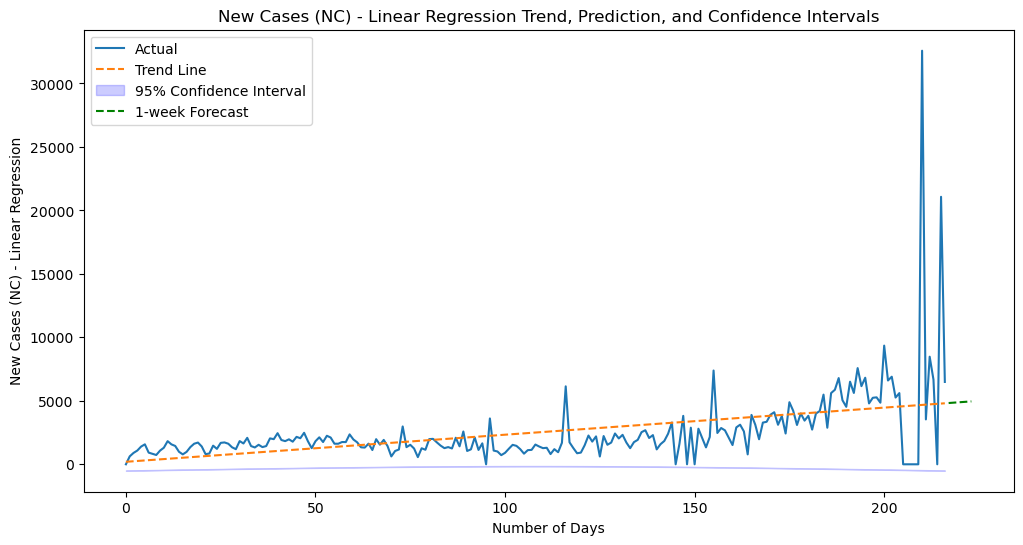

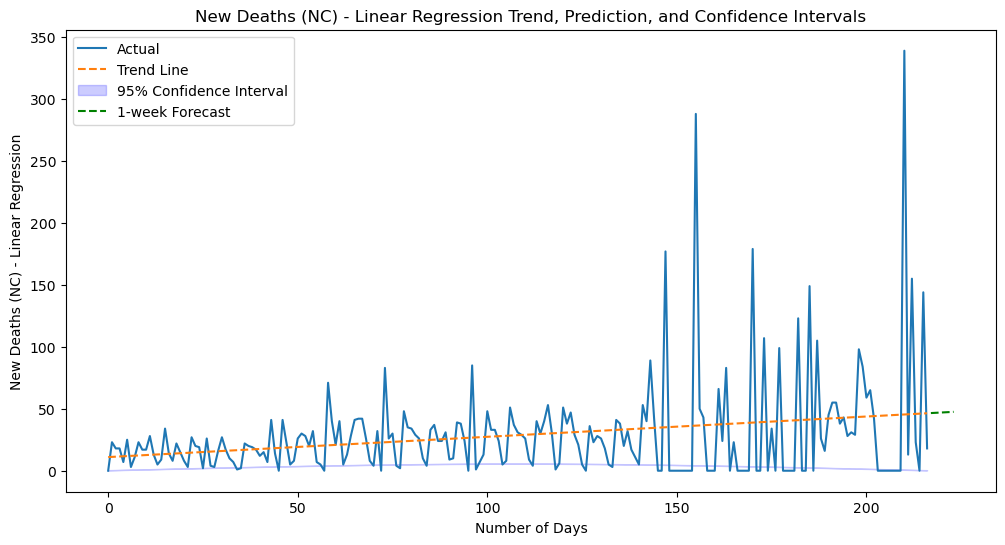

RMSE for Linear Regression (New Cases, NC): 2637.93
RMSE for Linear Regression (New Deaths, NC): 40.22


In [43]:
# Extracting X and y for the entire state of North Carolina
X_nc = np.arange(len(nc_data_filtered)).reshape(-1, 1)
y_nc_new_cases = nc_data_filtered['New Cases'].values
y_nc_new_deaths = nc_data_filtered['New Deaths'].values

# Fitting linear regression models
linear_model_new_cases_nc = fit_linear_regression(X_nc, y_nc_new_cases)
linear_model_new_deaths_nc = fit_linear_regression(X_nc, y_nc_new_deaths)

# Predictions for the entire state
y_pred_linear_new_cases_nc = linear_model_new_cases_nc.predict(X_nc)
y_pred_linear_new_deaths_nc = linear_model_new_deaths_nc.predict(X_nc)

# Calculating RMSE for North Carolina
rmse_linear_new_cases_nc = calculate_rmse(y_nc_new_cases, y_pred_linear_new_cases_nc)
rmse_linear_new_deaths_nc = calculate_rmse(y_nc_new_deaths, y_pred_linear_new_deaths_nc)


# Calculating confidence intervals for North Carolina
confidence_interval_nc_new_cases = calculate_confidence_intervals(linear_model_new_cases_nc, X_nc, y_nc_new_cases)
confidence_interval_nc_new_deaths = calculate_confidence_intervals(linear_model_new_deaths_nc, X_nc, y_nc_new_deaths)

# Plotting the results for North Carolina with confidence intervals
plot_regression_results(X_nc, y_nc_new_cases, y_pred_linear_new_cases_nc, 'New Cases (NC) - Linear Regression',
                        confidence_interval=confidence_interval_nc_new_cases,
                        forecast_dates=X_nc[-1] + np.arange(1, 8).reshape(-1, 1),
                        forecast_values=linear_model_new_cases_nc.predict(X_nc[-1] + np.arange(1, 8).reshape(-1, 1)))

plot_regression_results(X_nc, y_nc_new_deaths, y_pred_linear_new_deaths_nc, 'New Deaths (NC) - Linear Regression',
                        confidence_interval=confidence_interval_nc_new_deaths,
                        forecast_dates=X_nc[-1] + np.arange(1, 8).reshape(-1, 1),
                        forecast_values=linear_model_new_deaths_nc.predict(X_nc[-1] + np.arange(1, 8).reshape(-1, 1)))


print(f"RMSE for Linear Regression (New Cases, NC): {rmse_linear_new_cases_nc:.2f}")
print(f"RMSE for Linear Regression (New Deaths, NC): {rmse_linear_new_deaths_nc:.2f}")

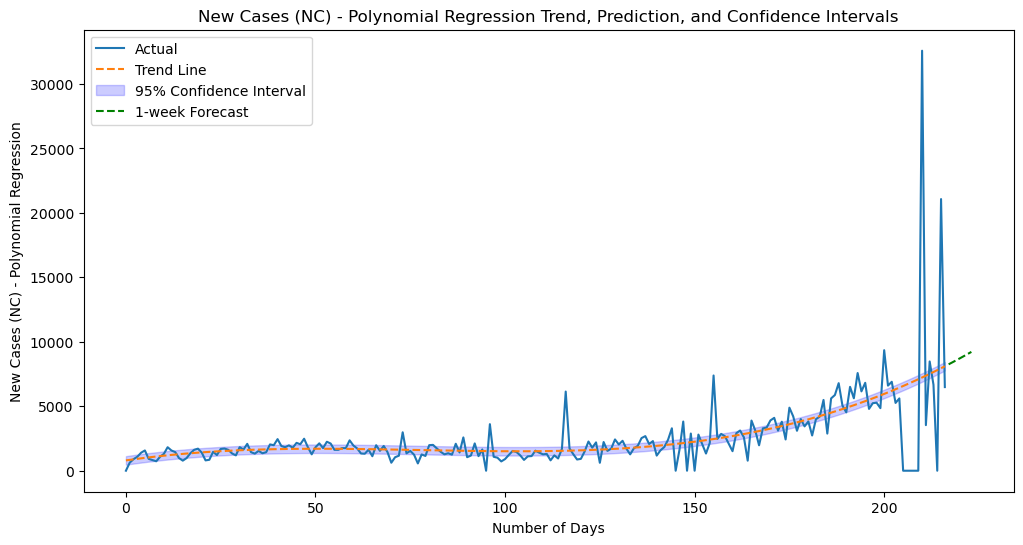

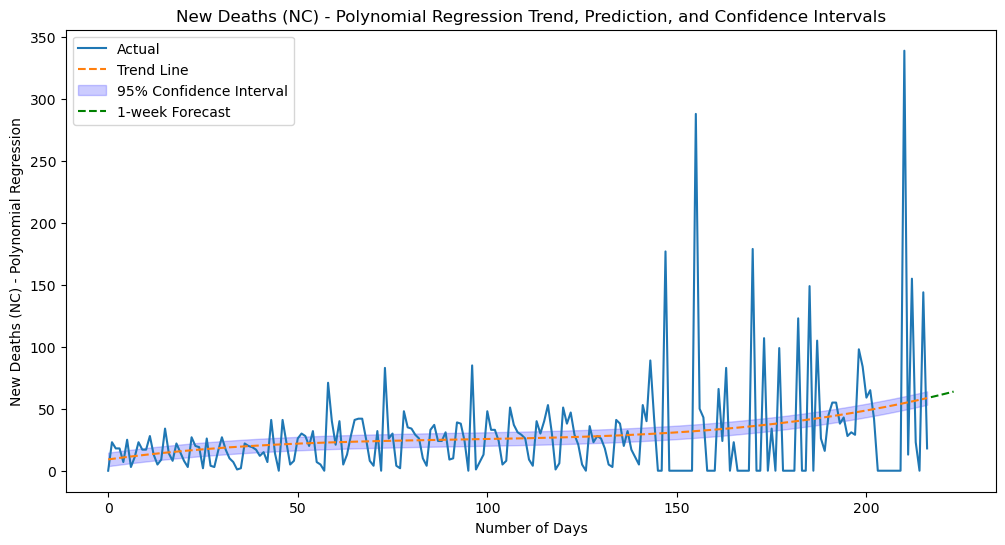

RMSE for Polynomial Regression (New Cases, NC): 2429.78
RMSE for Polynomial Regression (New Deaths, NC): 40.06


In [44]:
# Fitting polynomial regression models
degree = 3
poly_model_new_cases_nc, poly_nc = fit_polynomial_regression(X_nc, y_nc_new_cases, degree)
poly_model_new_deaths_nc, _ = fit_polynomial_regression(X_nc, y_nc_new_deaths, degree)

# Predictions for the entire state
X_poly_nc = poly_nc.transform(X_nc)
y_pred_poly_new_cases_nc = poly_model_new_cases_nc.predict(X_poly_nc)
y_pred_poly_new_deaths_nc = poly_model_new_deaths_nc.predict(X_poly_nc)

# Calculating RMSE for North Carolina
rmse_poly_new_cases_nc = calculate_rmse(y_nc_new_cases, y_pred_poly_new_cases_nc)
rmse_poly_new_deaths_nc = calculate_rmse(y_nc_new_deaths, y_pred_poly_new_deaths_nc)

# Calculating confidence intervals for Polynomial Regression in North Carolina
confidence_interval_poly_new_cases_nc = calculate_confidence_intervals_poly(poly_model_new_cases_nc, X_nc, poly_nc, y_nc_new_cases)
confidence_interval_poly_new_deaths_nc = calculate_confidence_intervals_poly(poly_model_new_deaths_nc, X_nc, poly_nc, y_nc_new_deaths)

# Plotting the results for North Carolina with confidence intervals and labels for Polynomial Regression
plot_regression_results_poly(X_nc, y_nc_new_cases, y_pred_poly_new_cases_nc, 'New Cases (NC) - Polynomial Regression',
                             poly_nc, confidence_interval=confidence_interval_poly_new_cases_nc,
                             forecast_dates=X_nc[-1] + np.arange(1, 8).reshape(-1, 1),
                             forecast_values=poly_model_new_cases_nc.predict(poly_nc.transform(X_nc[-1] + np.arange(1, 8).reshape(-1, 1))))

plot_regression_results_poly(X_nc, y_nc_new_deaths, y_pred_poly_new_deaths_nc, 'New Deaths (NC) - Polynomial Regression',
                             poly_nc, confidence_interval=confidence_interval_poly_new_deaths_nc,
                             forecast_dates=X_nc[-1] + np.arange(1, 8).reshape(-1, 1),
                             forecast_values=poly_model_new_deaths_nc.predict(poly_nc.transform(X_nc[-1] + np.arange(1, 8).reshape(-1, 1))))

print(f"RMSE for Polynomial Regression (New Cases, NC): {rmse_poly_new_cases_nc:.2f}")
print(f"RMSE for Polynomial Regression (New Deaths, NC): {rmse_poly_new_deaths_nc:.2f}")


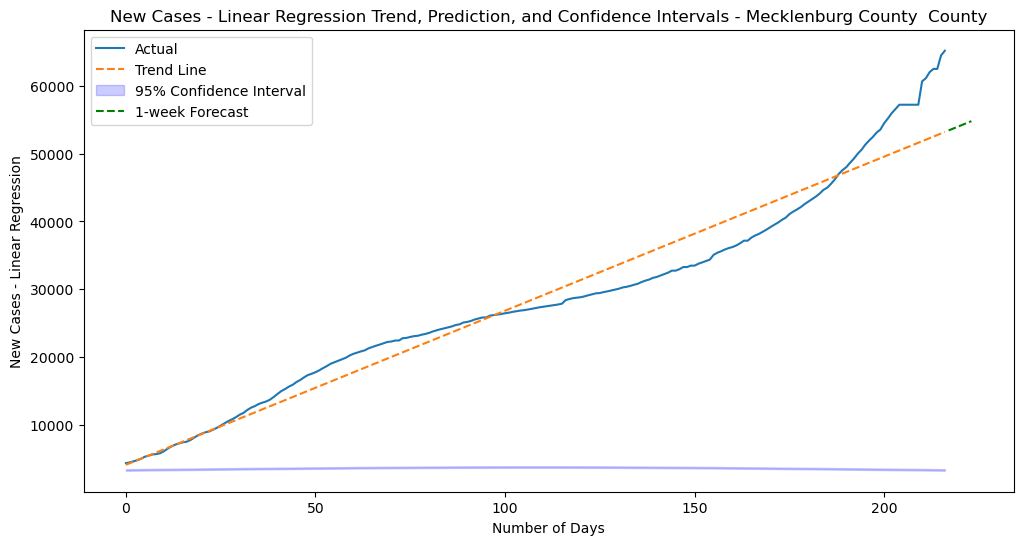

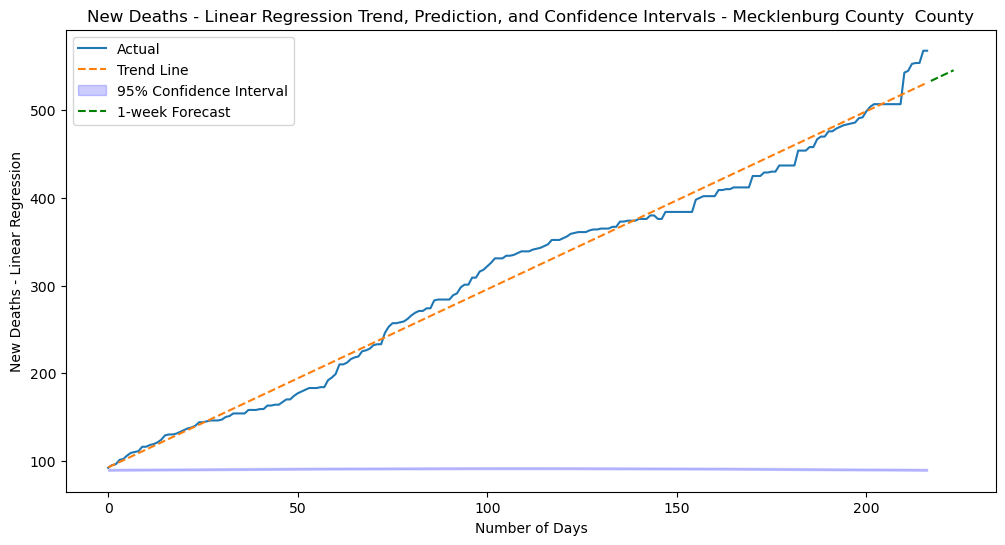


Mecklenburg County  County:
RMSE for Linear Regression (New Cases): 3272.67
RMSE for Linear Regression (New Deaths): 14.39


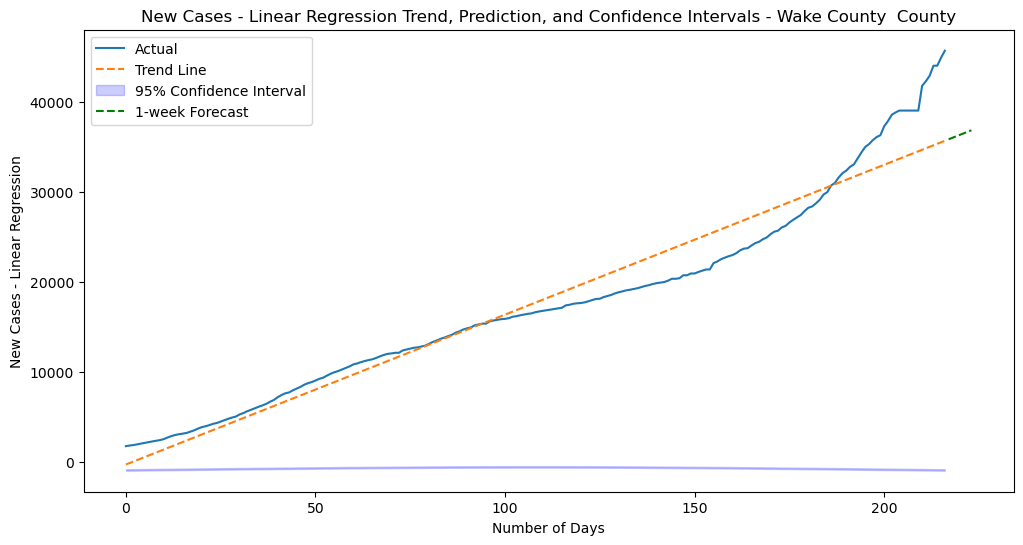

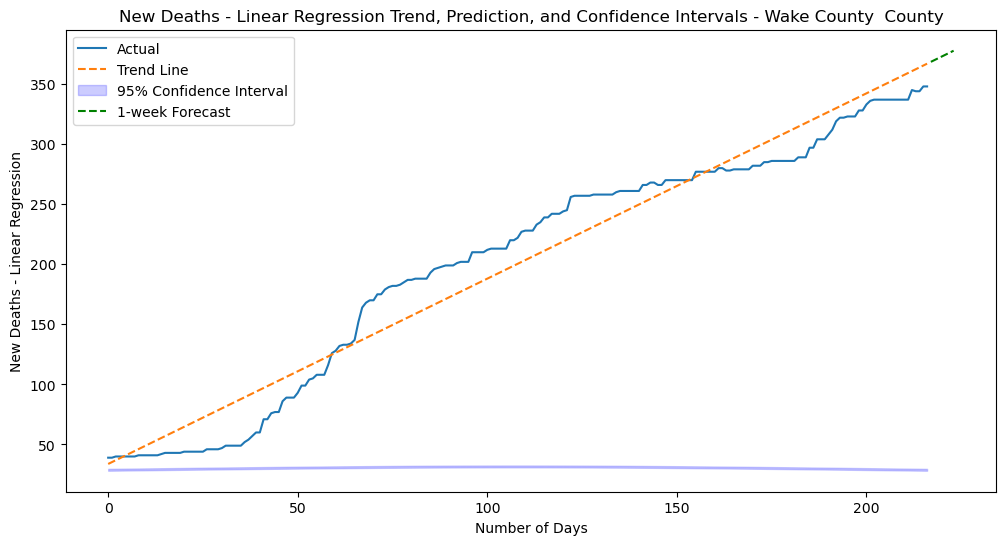


Wake County  County:
RMSE for Linear Regression (New Cases): 2601.16
RMSE for Linear Regression (New Deaths): 21.14


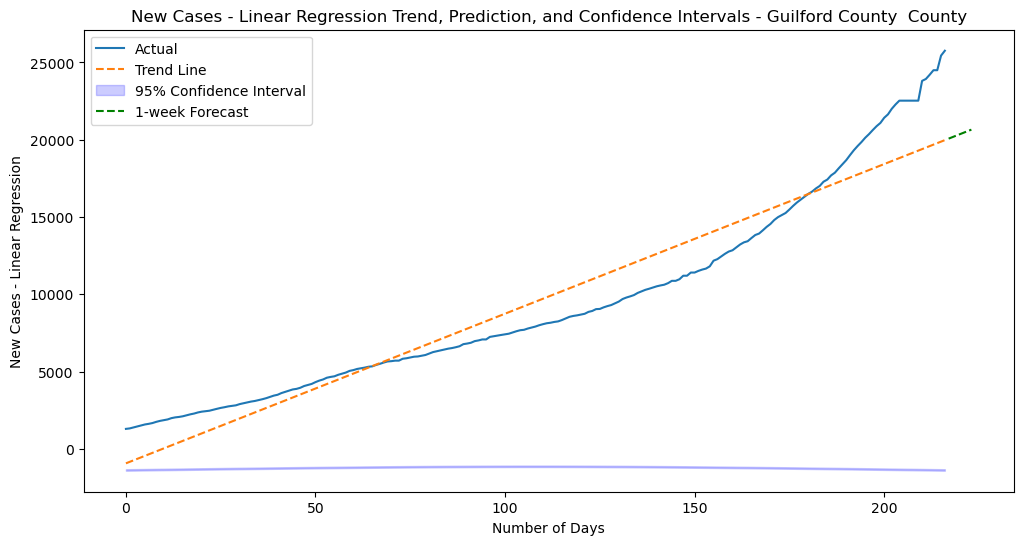

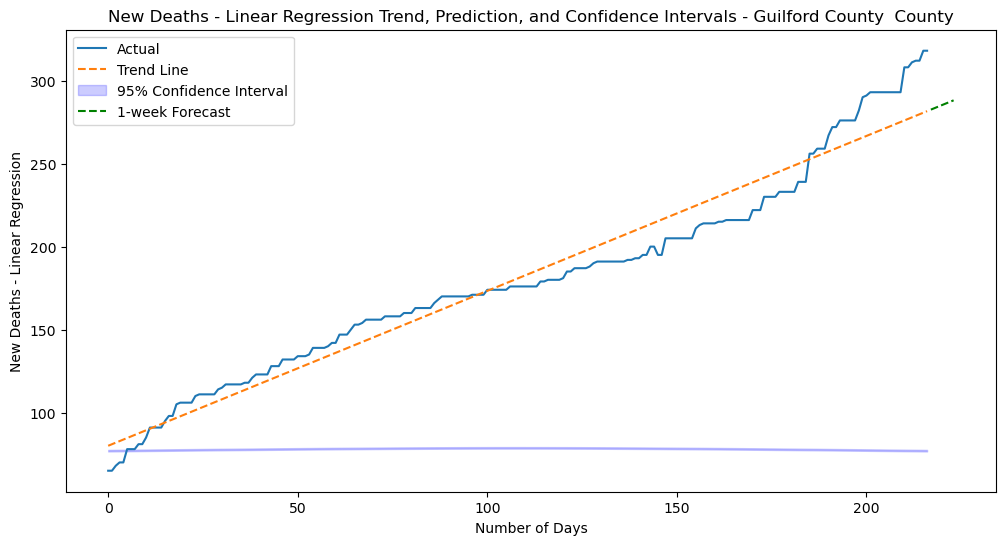


Guilford County  County:
RMSE for Linear Regression (New Cases): 1793.53
RMSE for Linear Regression (New Deaths): 12.84


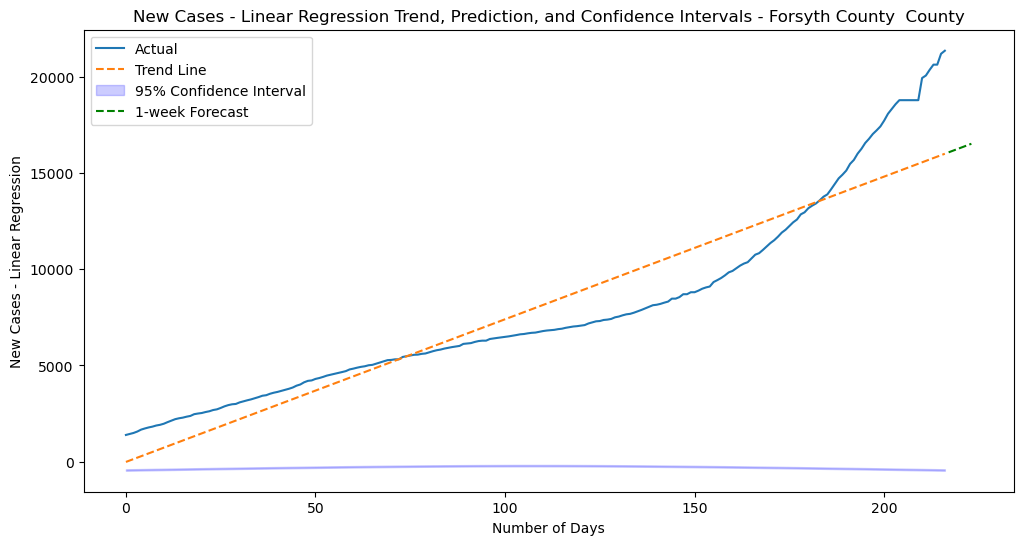

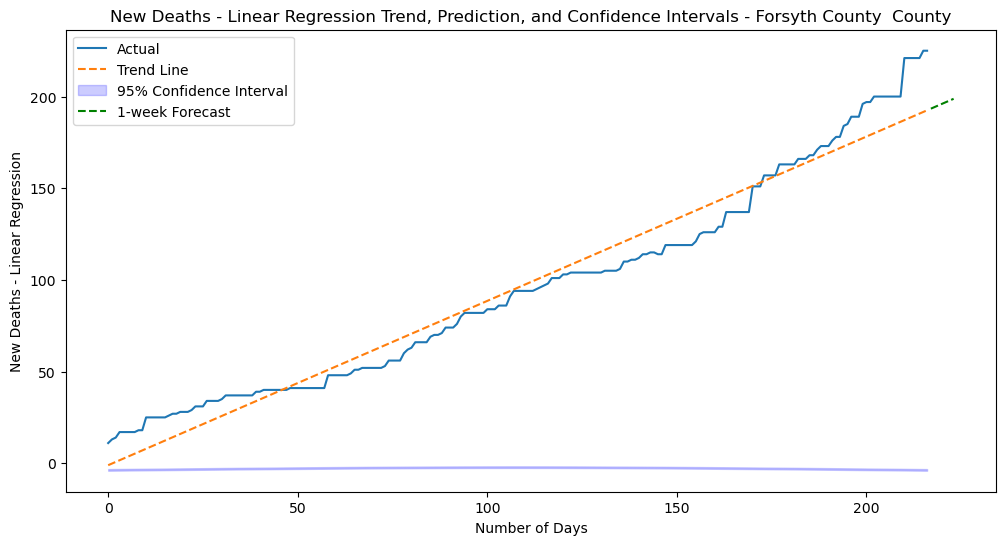


Forsyth County  County:
RMSE for Linear Regression (New Cases): 1714.95
RMSE for Linear Regression (New Deaths): 11.31


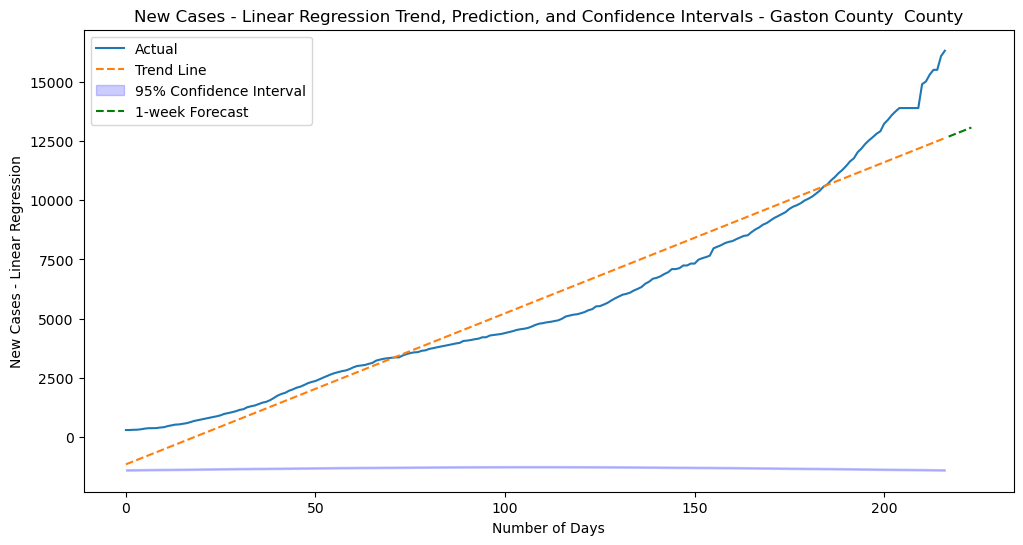

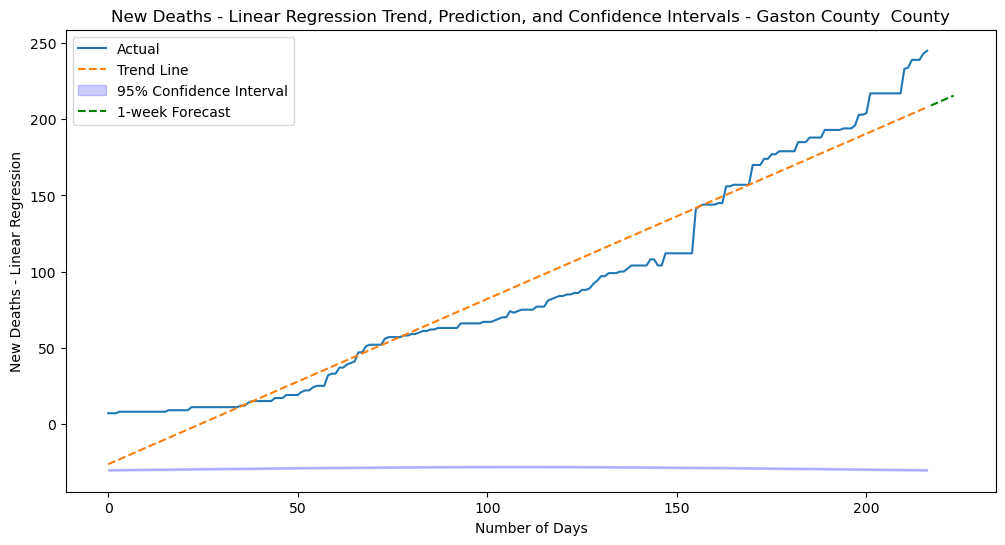


Gaston County  County:
RMSE for Linear Regression (New Cases): 1015.37
RMSE for Linear Regression (New Deaths): 16.10


In [45]:
# Identify top 5 counties
top_counties_list = top_counties(nc_data)

# Plotting regression results for each county
for county in top_counties_list:
    county_data = nc_data[nc_data['County Name'] == county]
    X_county = np.arange(len(county_data)).reshape(-1, 1)
    y_county_new_cases = county_data['Cases'].values
    y_county_new_deaths = county_data['Deaths'].values

    # Linear regression models
    linear_model_new_cases_county = fit_linear_regression(X_county, y_county_new_cases)
    linear_model_new_deaths_county = fit_linear_regression(X_county, y_county_new_deaths)
    
    # Predictions
    y_pred_linear_new_cases_county = linear_model_new_cases_county.predict(X_county)
    y_pred_linear_new_deaths_county = linear_model_new_deaths_county.predict(X_county)

    # Calculating RMSE for each county
    rmse_linear_new_cases_county = calculate_rmse(y_county_new_cases, y_pred_linear_new_cases_county)
    rmse_linear_new_deaths_county = calculate_rmse(y_county_new_deaths, y_pred_linear_new_deaths_county)
    
    # Calculating confidence intervals
    confidence_interval_new_cases_county = calculate_confidence_intervals(linear_model_new_cases_county, X_county, y_county_new_cases)
    confidence_interval_new_deaths_county = calculate_confidence_intervals(linear_model_new_deaths_county, X_county, y_county_new_deaths)

    # Plotting the results for each county with confidence intervals
    plot_county_regression(county_data, county, X_county, y_county_new_cases,
                           y_pred_linear_new_cases_county, 'New Cases - Linear Regression',
                           confidence_interval=confidence_interval_new_cases_county,
                           forecast_dates=X_county[-1] + np.arange(1, 8).reshape(-1, 1),
                           forecast_values=linear_model_new_cases_county.predict(X_county[-1] + np.arange(1, 8).reshape(-1, 1)))
    
    plot_county_regression(county_data, county, X_county, y_county_new_deaths,
                           y_pred_linear_new_deaths_county, 'New Deaths - Linear Regression',
                           confidence_interval=confidence_interval_new_deaths_county,
                           forecast_dates=X_county[-1] + np.arange(1, 8).reshape(-1, 1),
                           forecast_values=linear_model_new_deaths_county.predict(X_county[-1] + np.arange(1, 8).reshape(-1, 1)))

    print(f"\n{county} County:")
    print(f"RMSE for Linear Regression (New Cases): {rmse_linear_new_cases_county:.2f}")
    print(f"RMSE for Linear Regression (New Deaths): {rmse_linear_new_deaths_county:.2f}")


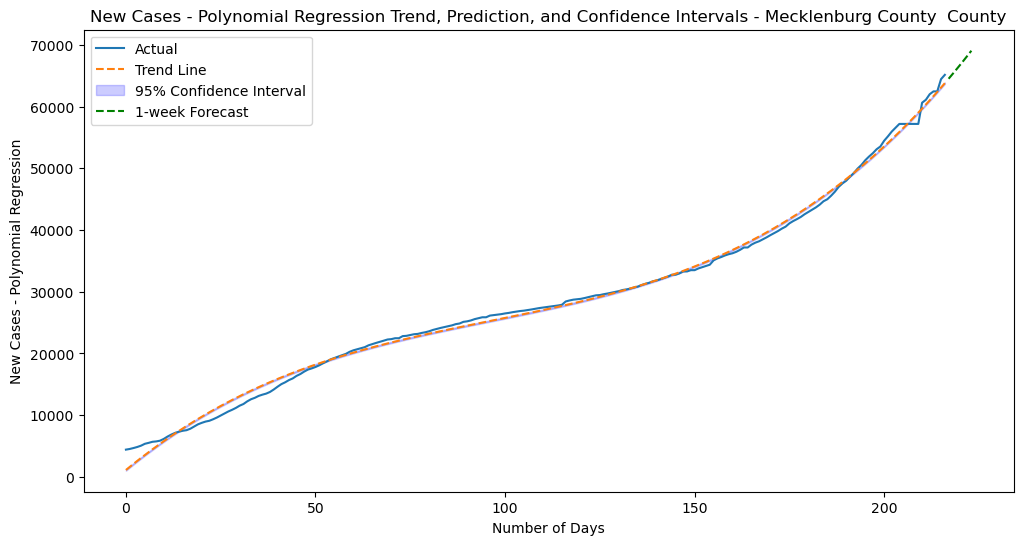

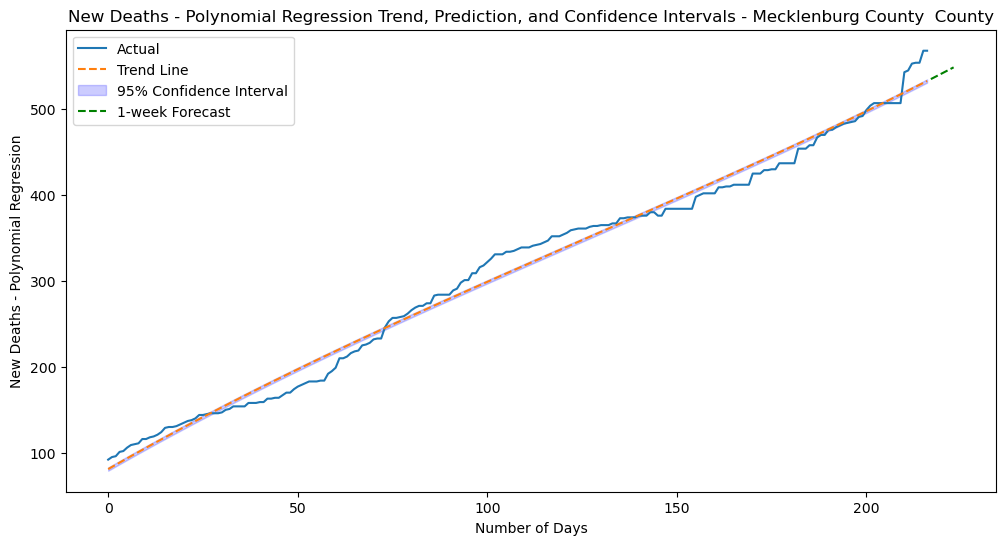


Mecklenburg County  County:
RMSE for Polynomial Regression (New Cases): 854.40
RMSE for Polynomial Regression (New Deaths): 13.98


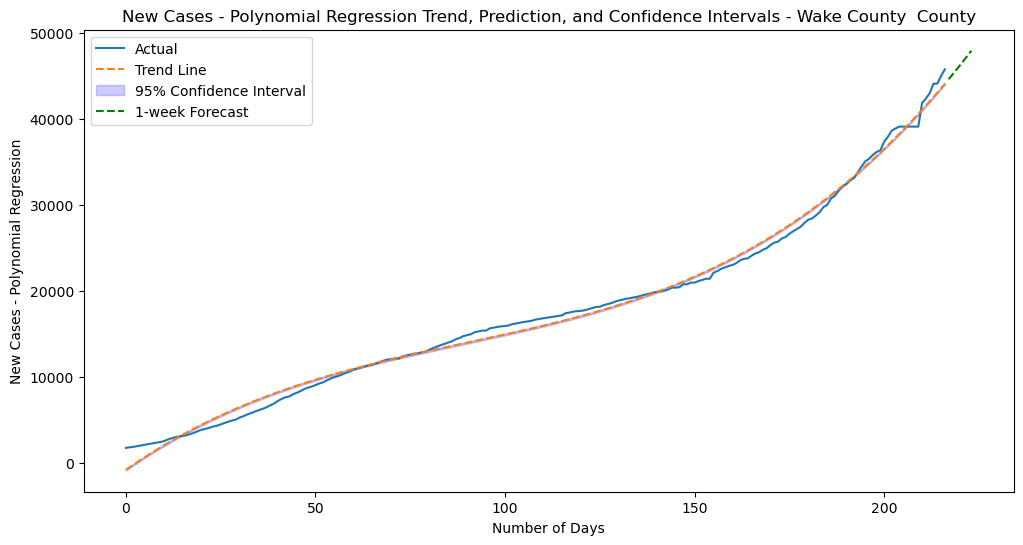

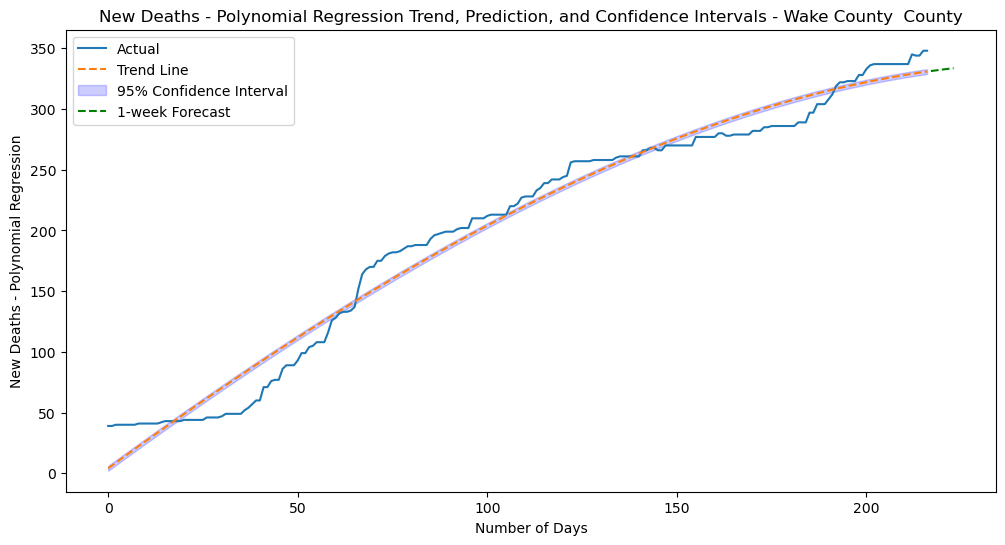


Wake County  County:
RMSE for Polynomial Regression (New Cases): 815.58
RMSE for Polynomial Regression (New Deaths): 14.94


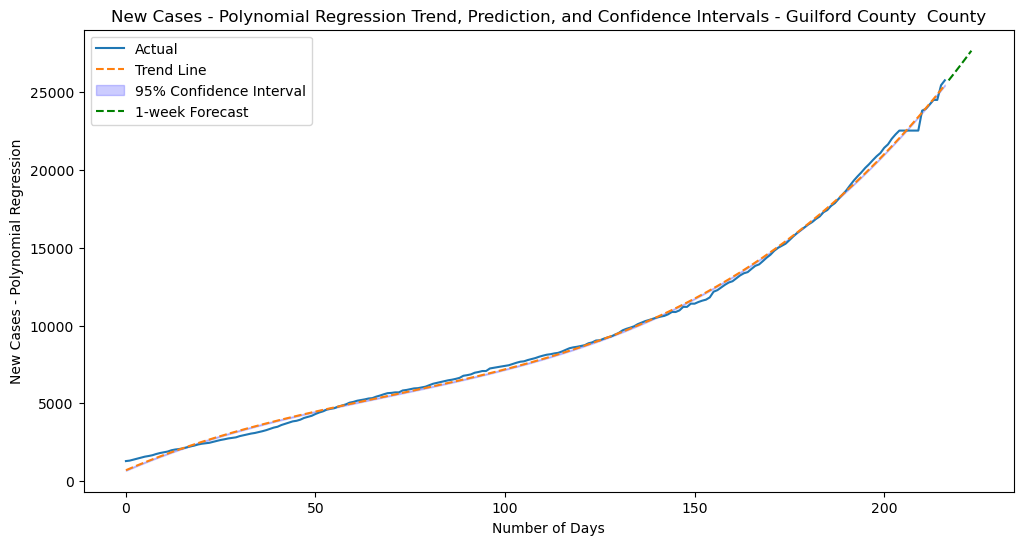

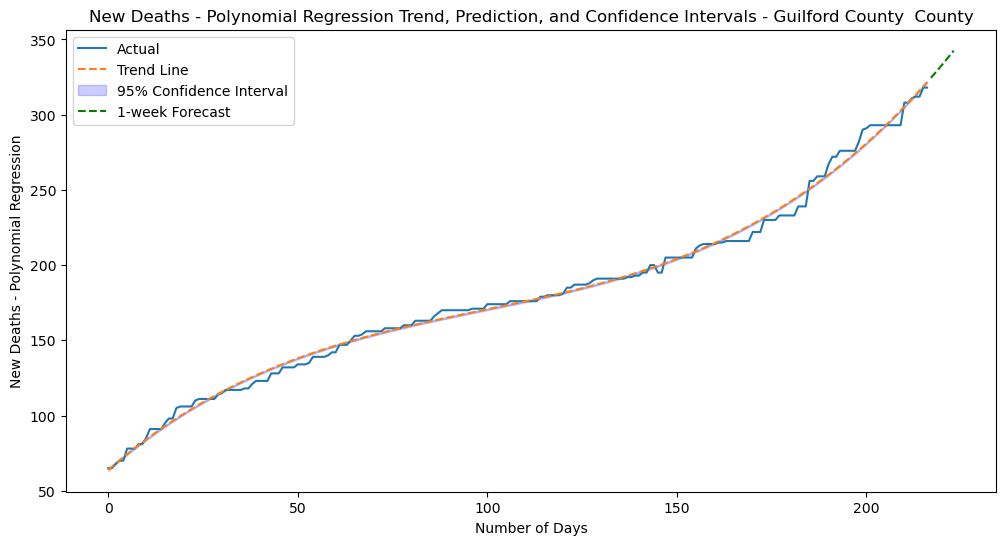


Guilford County  County:
RMSE for Polynomial Regression (New Cases): 240.85
RMSE for Polynomial Regression (New Deaths): 4.06


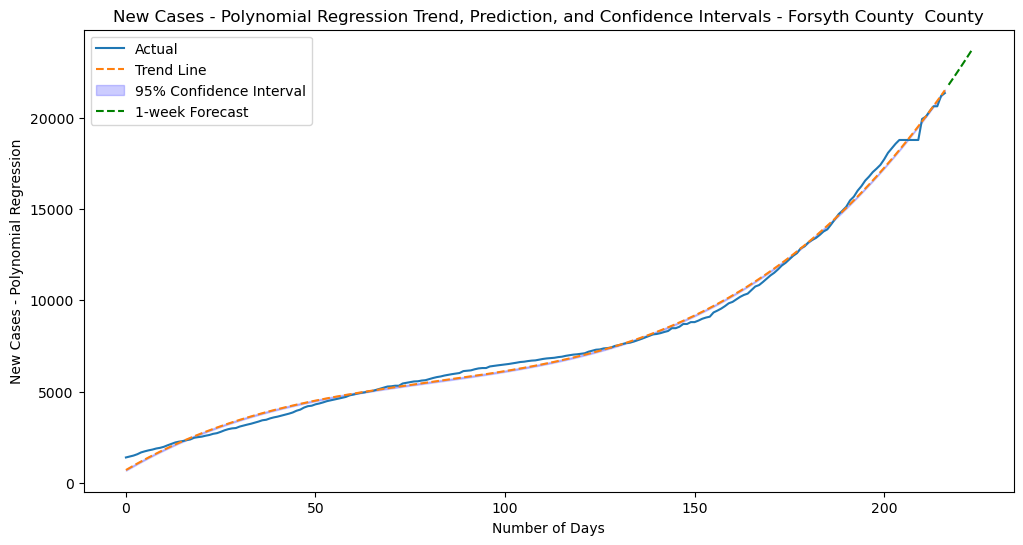

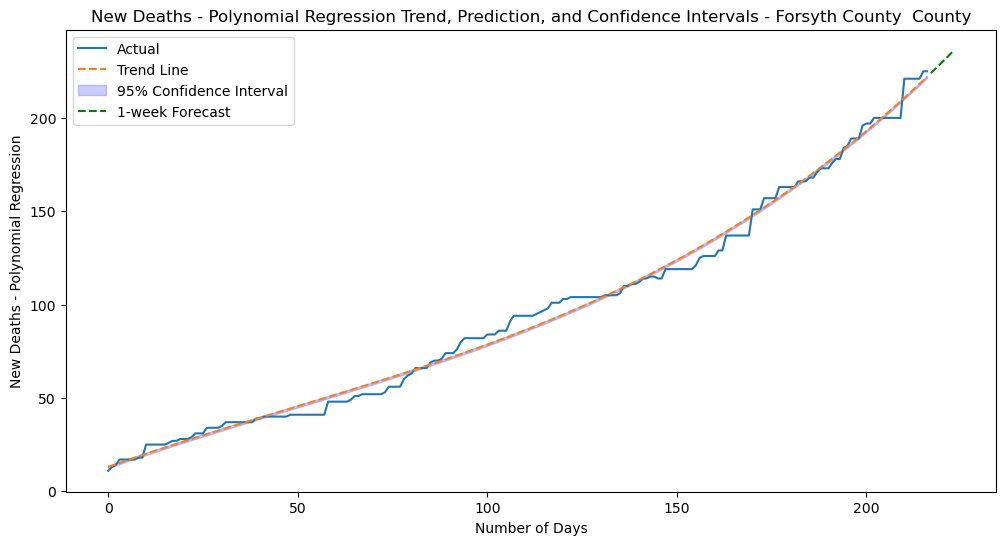


Forsyth County  County:
RMSE for Polynomial Regression (New Cases): 281.39
RMSE for Polynomial Regression (New Deaths): 4.59


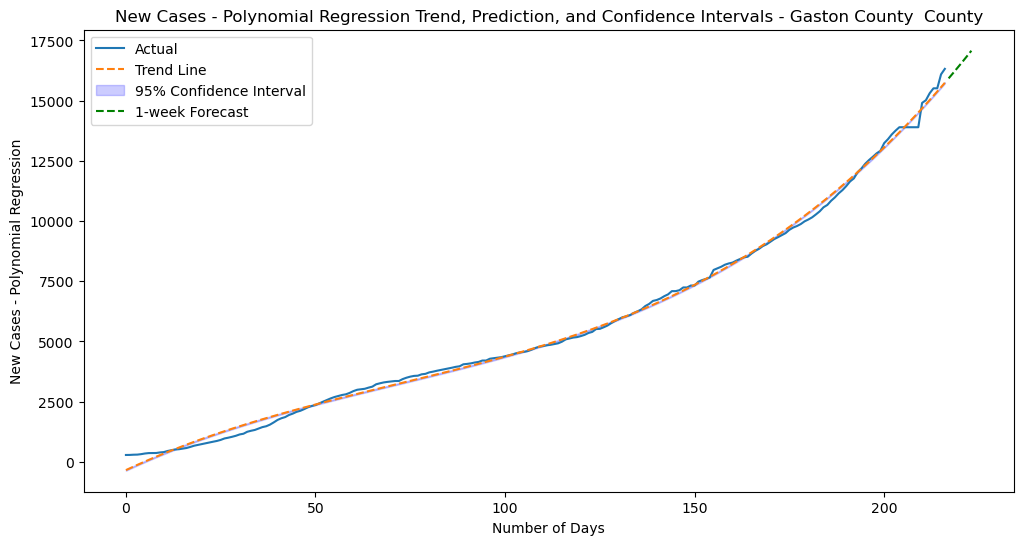

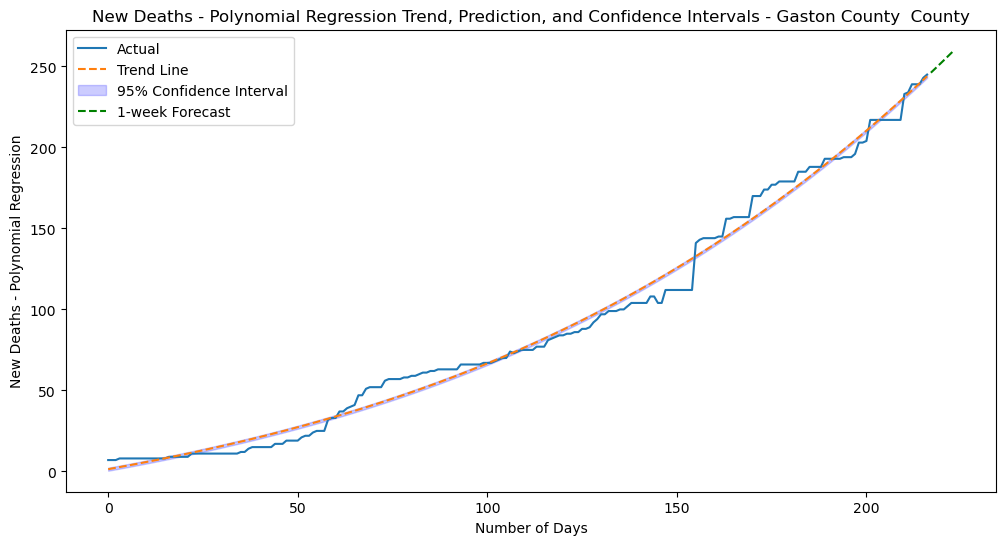


Gaston County  County:
RMSE for Polynomial Regression (New Cases): 191.21
RMSE for Polynomial Regression (New Deaths): 6.90


In [46]:
# Plotting regression results for each county
for county in top_counties_list:
    county_data = nc_data[nc_data['County Name'] == county]
    X_county = np.arange(len(county_data)).reshape(-1, 1)
    y_county_new_cases = county_data['Cases'].values
    y_county_new_deaths = county_data['Deaths'].values

    # Polynomial regression models
    poly_model_new_cases_county, poly_county = fit_polynomial_regression(X_county, y_county_new_cases, degree)
    poly_model_new_deaths_county, _ = fit_polynomial_regression(X_county, y_county_new_deaths, degree)

    # Predictions
    X_poly_county = poly_county.transform(X_county)
    y_pred_poly_new_cases_county = poly_model_new_cases_county.predict(X_poly_county)
    y_pred_poly_new_deaths_county = poly_model_new_deaths_county.predict(X_poly_county)

    # Calculating RMSE for each county
    rmse_poly_new_cases_county = calculate_rmse(y_county_new_cases, y_pred_poly_new_cases_county)
    rmse_poly_new_deaths_county = calculate_rmse(y_county_new_deaths, y_pred_poly_new_deaths_county)
    
    # Calculating Confidence Intervals
    confidence_interval_poly_new_cases_county = calculate_confidence_intervals_poly(poly_model_new_cases_county, X_county, poly_county, y_county_new_cases)
    confidence_interval_poly_new_deaths_county = calculate_confidence_intervals_poly(poly_model_new_deaths_county, X_county, poly_county, y_county_new_deaths)

    # Plotting the results for each county with confidence intervals and labels for polynomial regression
    plot_county_regression(county_data, county, X_county, y_county_new_cases,
                           y_pred_poly_new_cases_county, 'New Cases - Polynomial Regression',
                           confidence_interval=confidence_interval_poly_new_cases_county,
                           forecast_dates=X_county[-1] + np.arange(1, 8).reshape(-1, 1),
                           forecast_values=poly_model_new_cases_county.predict(poly_county.transform(X_county[-1] + np.arange(1, 8).reshape(-1, 1))))
    
    plot_county_regression(county_data, county, X_county, y_county_new_deaths,
                           y_pred_poly_new_deaths_county, 'New Deaths - Polynomial Regression',
                           confidence_interval=confidence_interval_poly_new_deaths_county,
                           forecast_dates=X_county[-1] + np.arange(1, 8).reshape(-1, 1),
                           forecast_values=poly_model_new_deaths_county.predict(poly_county.transform(X_county[-1] + np.arange(1, 8).reshape(-1, 1))))


    print(f"\n{county} County:")
    print(f"RMSE for Polynomial Regression (New Cases): {rmse_poly_new_cases_county:.2f}")
    print(f"RMSE for Polynomial Regression (New Deaths): {rmse_poly_new_deaths_county:.2f}")


Taken 95 percent CI, as it is a common statistical practice, where we would be expecting the true parameter (slope in regression) to fall within interval in approximately 95% of replications.